# Audio Spectrum Display Simulation
This notebook is used to generate sinewayes samples to use them for testing in embedded system. Samples are then transformed using FFT and then visualise. The bins-bands LUT is evaluated. Then tests are made. Signal is processed on STM32F4 then it is compared with visualization. Thresholding is used to remove noise in frequency domain and then reconstructed. Comparison is dome. Then DAC is used to generate sine wave with variable frequency.

For further informations check out [Github](https://github.com/Gieneq/Spectrum_Audio_Display_V2)

## Assumptions

* Sampling frequency: 44 kHz (it can sligtly change depending on available hardware resources),
* Max frequency in the signal (Nyquist theorem): 22 kHz,
* Numbber of FFT samples: 1024,
* Numbber of FFT bins: 512 (half of FFT samples),
* Number of bands: 19,
* Bins to bands assignment function: exponential with variable exponent factor.

The goal is to achieve FFT refreshrate of not **less then 30 Hz**. STM32F4 IC will be used to sample signal with builtin 12 bit ultra-fast SAR ADC.

To let hardware ADC sampling and simultenously evaluating FFT double buffering is done. Toal length of samples buffer: 2048. When half of buffer is filled interrupt is invoken to trigger FFT. Only one half of samples is used to evaluate FFT. Evaluation time cannot exceed sampling time.



In [43]:
sampling_frequency = 44e3  # Hz
refresh_rate_cap = 30      # Hz

# Sampling time
More FFT points means longer sampling time. By using 44 kHz sampling rate the overall refresh rate can drop below 30 Hz cap quite fast. It can be avoided by double buffering samples and windowing. In comparison the time of evaluating the FFT on STM32 using the CMSIS library is neglibli short (see further).

Considered FFT resolution: [128, 256, 512, 1024, 2048, 4096]
Refresh rate cap: {128: 344, 256: 172, 512: 86, 1024: 43, 2048: 21, 4096: 11} [points:Hz]
Max FFT points: 1024 with 43 Hz refresh rate.


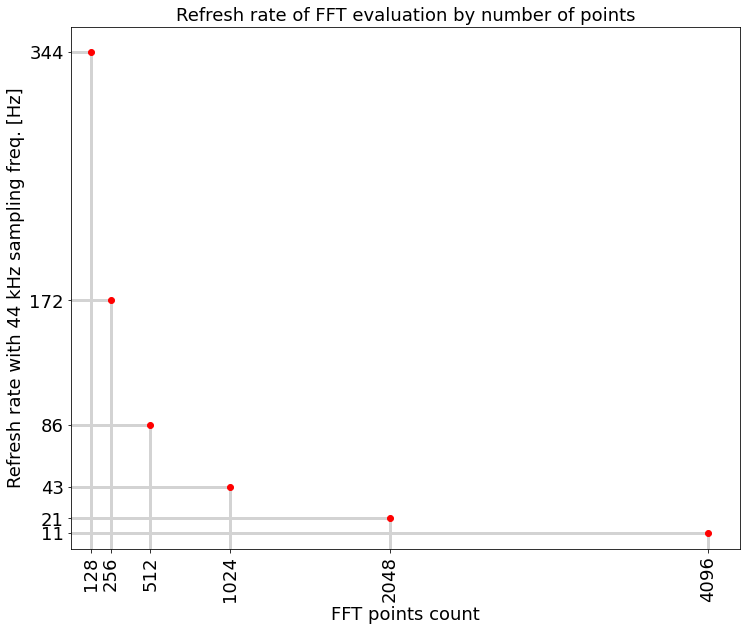

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import pi, floor

plots_scale = 0.8
plt.rcParams['figure.figsize'] = [plots_scale*15, plots_scale*12]

fft_points_options = [2**i for i in range(7,13)]
print(f"Considered FFT resolution: {fft_points_options}")
sampling_time = [1000*points/sampling_frequency for points in fft_points_options]
point_fps_dict = dict(zip(fft_points_options, [round(sampling_frequency/points) for points in fft_points_options]))
freqs_by_ftt_points = list(point_fps_dict.values())
print(f"Refresh rate cap: {point_fps_dict} [points:Hz]")

inv_point_fps_dict = dict(zip(point_fps_dict.values(), point_fps_dict.keys()))
available_options = sorted({val:key for key, val in point_fps_dict.items() if val > refresh_rate_cap}.items(), reverse=False, key=lambda x: x[0])
best_option = available_options[0]
print(f"Max FFT points: {best_option[1]} with {best_option[0]} Hz refresh rate.")


for x, y in zip(fft_points_options, freqs_by_ftt_points):
    plt.plot([x, x],[0,y], color='lightgray', linestyle='-', linewidth=3)
    plt.plot([0, x],[y,y], color='lightgray', linestyle='-', linewidth=3)
    
plt.plot(fft_points_options, freqs_by_ftt_points, "or")

plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xticks(fft_points_options, rotation=90, fontsize= 18)
plt.yticks(freqs_by_ftt_points, fontsize= 18)

plt.xlabel("FFT points count", fontsize=18)
plt.ylabel(f'Refresh rate with {round(sampling_frequency/1000)} kHz sampling freq. [Hz]', fontsize=18)
plt.title(f"Refresh rate of FFT evaluation by number of points", fontsize=18)
plt.show()


## Example results - FFT evaluation time

```
START INPUT SIGNAL 1024:

... (check files for more results)

START TEST, IT WILL TAKE 10000 MS...
STOP TEST! DONE 51196 ITERATIONS AND (WITH 1024 FFT POINTS) GOT 5119 Hz REFRESH RATE (T = 195 US), ERROR: 0.031%.
```

AS can be seen evaluation time for 1024 points FFT takes 195 us. In comparison with refresh rate of 43Hz (capped by sampling rate) sampling time is 23.25 ms which is 119 times longer than FFT evaluation.


In [45]:
print((1000/43)/0.195)

119.26058437686343


To further increase reshresh rate of FFt without changing samples count windowing can be used - 1024 samples could be used with smaller window shift than half of buffer length. It is not required in this project.

# Input signal
Generating input signal with 2 main frequencies and added white noise. This signal will be processed on embedded system to compare results with simulation.

Sampling time: 46.55 ms of 2048 samples with 44000.0 sps
// Data generated using Jupyter Notebook. The signal mixes 210 Hz, 12000.0 Hz and white noise.
Normalize results:  -1.0 1.0
Normalize results:  0 4095


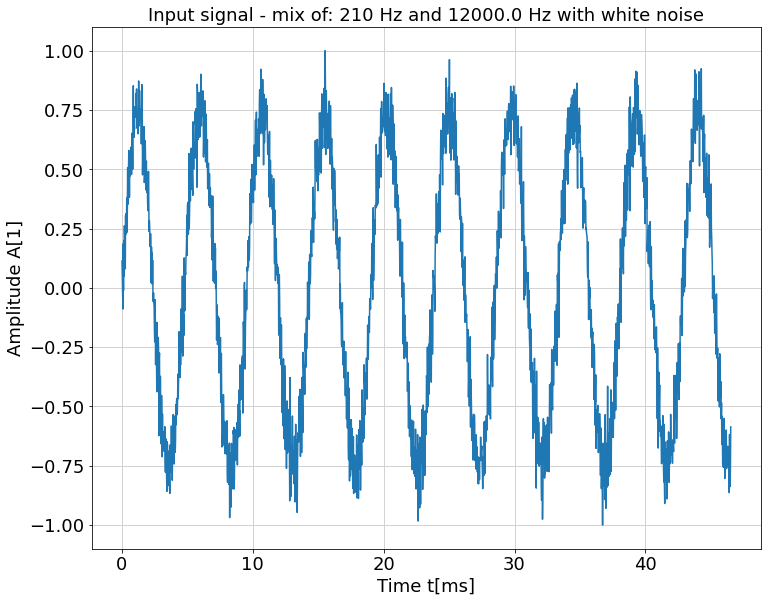

In [46]:
from sklearn.preprocessing import normalize

# Twice as many samples are needed
samples_count = 1024*2

# Testing frequencies
frequency_1 = 210 #30
frequency_2 = 12e3 #19999

np.random.seed(1)
noise = np.random.normal(loc=0, scale=0.1, size=samples_count)

sampling_time = samples_count * 1/sampling_frequency
print(f"Sampling time: {round(sampling_time*1000, 2)} ms of {samples_count} samples with {sampling_frequency} sps")

t = np.arange(samples_count)/sampling_frequency
val = np.sin(2*pi*frequency_1*t) + 0.1 * np.sin(2*pi*frequency_2*t) +noise
print(f"// Data generated using Jupyter Notebook. The signal mixes {frequency_1} Hz, {frequency_2} Hz and white noise.")

v_min = min(val)
v_max = max(val)
val = (val - v_min) / (v_max - v_min)
val = val * 2 - 1

print('Normalize results: ', min(val), max(val))
# val = [floor(4095 * v) for v in v_norm.astype('float32').tolist()]
# print('Normalize results 4096: ', min(val), max(val))

v_4096 = val.copy()
v_4096 = (v_4096 + 1) * (4096 - 1) / 2
v_4096 = v_4096.astype('int')
print('Normalize results: ', min(v_4096), max(v_4096))


plt.plot(t*1000, val)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.xlabel("Time t[ms]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title(f"Input signal - mix of: {frequency_1} Hz and {frequency_2} Hz with white noise", fontsize=18)
plt.show()


# FFT Evaluation
Fast Fourier Transformation allows converting time-base samples of the signal to frequency-based magnitudes. The magnitude depict the content of specific frequency in the signal. On the magnitude plot there are visible 2 lobes: on on the left side (low frequencies) one on the right side (higher frequencies).

Mags count: 1024


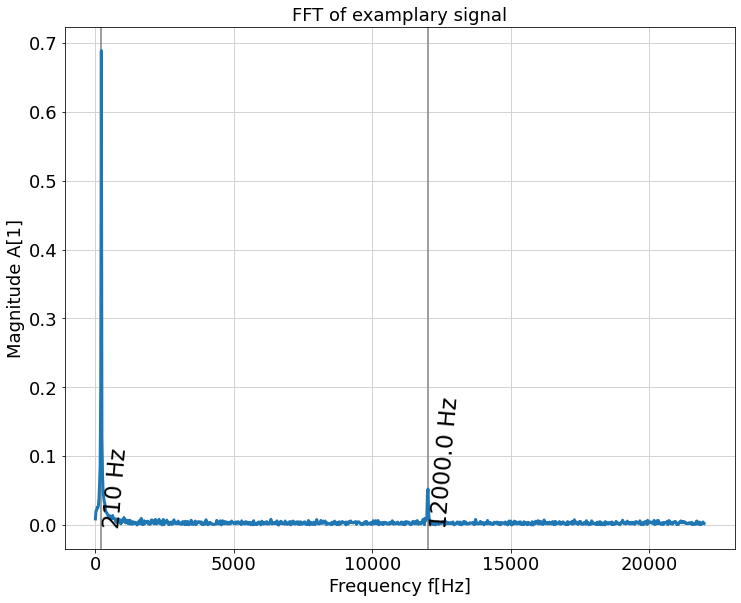

In [47]:
import scipy.fftpack


yf = scipy.fftpack.fft(val)
xf = sampling_frequency*np.arange(samples_count)/samples_count

freqs = xf[:samples_count//2]
mags = 2.0/samples_count * np.abs(yf[:samples_count//2])
print(f"Mags count: {len(mags)}")

sig_fft_real = yf.real
sig_fft_imag = yf.imag

plt.axvline(x=frequency_1, c="gray")
plt.axvline(x=frequency_2, c="gray")
plt.plot(freqs, mags, linewidth=3)
# plt.xscale("log")
# plt.yscale("log")
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.text(frequency_1, 1e-3, f"{frequency_1} Hz", fontsize = 23, rotation=85)
plt.text(frequency_2, 1e-3, f"{frequency_2} Hz", fontsize = 23, rotation=85)
plt.xlabel("Frequency f[Hz]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal', fontsize=18)
plt.show()

# Bins and bands

In some cases all resulting FFT magnitude samples are not needed. They can be condensated using bands. Each bands represents specific frequency range in which corresponding frequency magnitudes are added.

To help evalueating this process **bins LUT** (Lookup table) is made.

Worth mentioning is that it is better to use exponential function to calculate bins indices. You can compare it by looking at FFT with or without logscale. Low frequencies are visualised more precisely than higher ones. In contrast, when using the linear function all bands will have the same band widths.


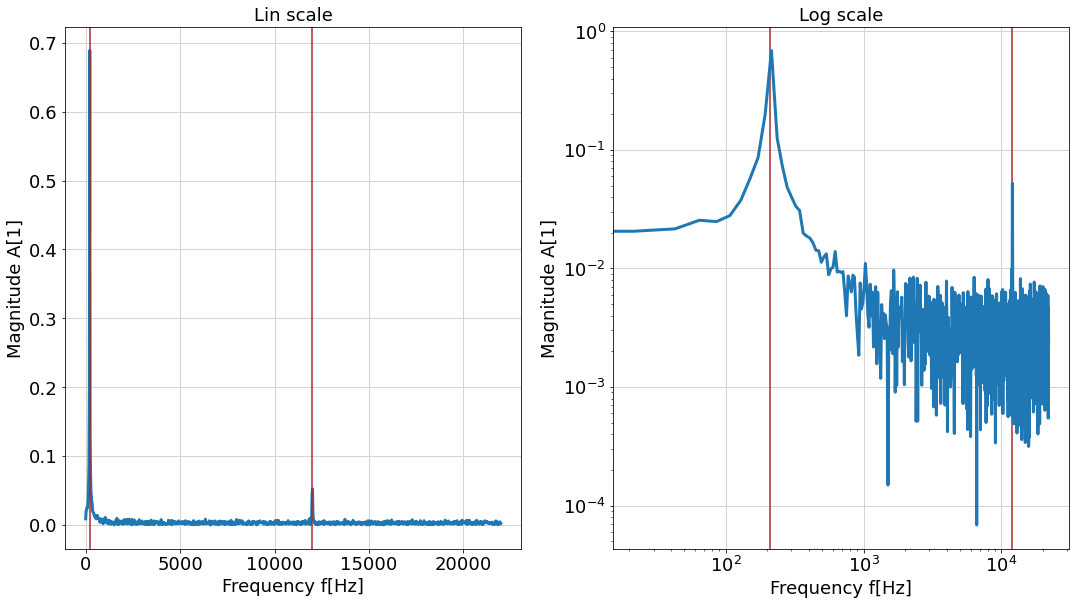

In [48]:
plt.rcParams['figure.figsize'] = [plots_scale*15*1.5, plots_scale*12]

plt.subplot(1, 2, 1)
plt.plot(freqs, mags, linewidth=3)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.axvline(x=frequency_1, c="brown")
plt.axvline(x=frequency_2, c="brown")
plt.xlabel("Frequency f[Hz]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'Lin scale', fontsize=18)

plt.subplot(1, 2, 2)
plt.xscale("log")
plt.yscale("log")
plt.axvline(x=frequency_1, c="brown")
plt.axvline(x=frequency_2, c="brown")
plt.plot(freqs, mags, linewidth=3)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.xlabel("Frequency f[Hz]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'Log scale', fontsize=18)

plt.show()

plt.rcParams['figure.figsize'] = [plots_scale*15, plots_scale*12]

# Bins function
Using exponential function with variable exponent the suitable convertion can be achieved.

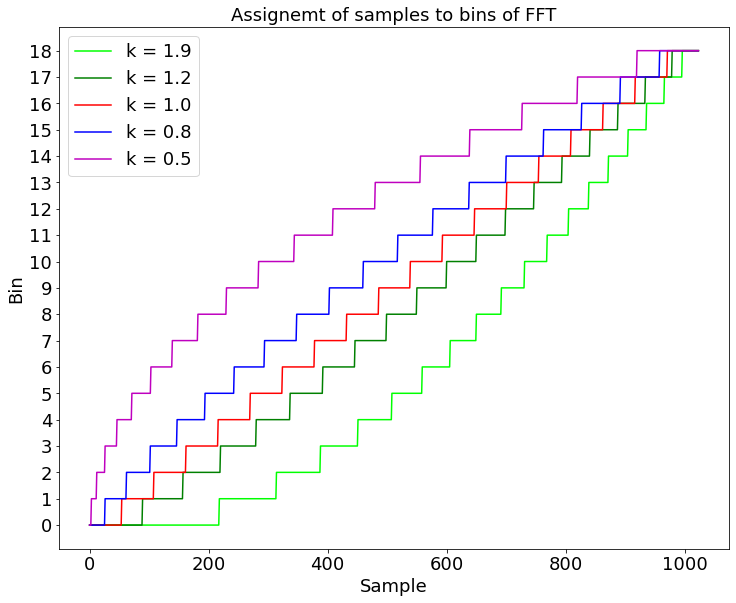

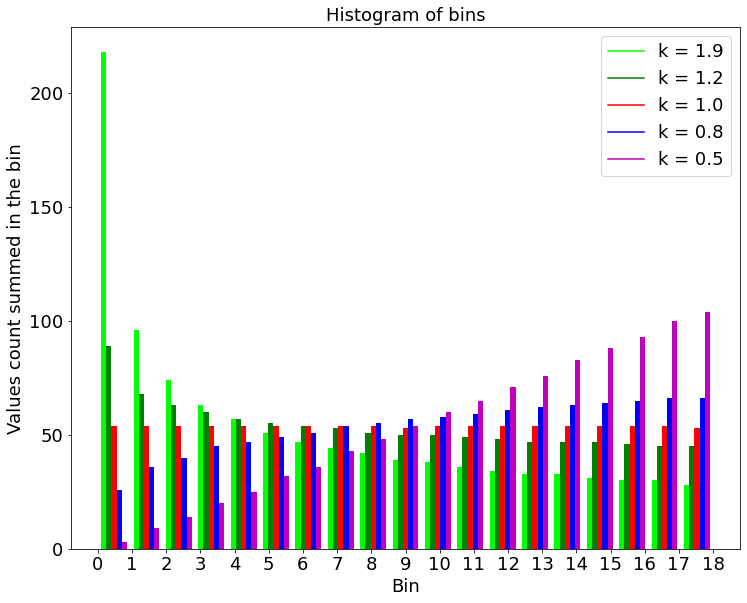

In [49]:
from collections import Counter
from math import floor

bands_count = 19

def gen_bins(bands_count, samples_count, k=1.0):
  return [floor(bands_count*(i/samples_count)**k) for i in range(0, samples_count)]


samples_idx = [i for i in range(0, samples_count // 2)]

k_factors = [1.9, 1.2, 1.0, 0.8, round(1/2, 2)]
plot_colors = ['lime', 'g', 'r', 'b', 'm']
plot_labels = [f"k = {k}" for k in k_factors]
bins_per_k = [gen_bins(bands_count, samples_count // 2, k) for k in k_factors]

plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

lines = [plt.plot(samples_idx, [str(bin) for bin in bins], plot_colors[idx])[0] for idx, bins in enumerate(bins_per_k)]
plt.title('Assignemt of samples to bins of FFT', fontsize=18)
plt.ylabel('Bin', fontsize=18)
plt.xlabel('Sample', fontsize=18);
plt.legend(lines, plot_labels, fontsize=18)
plt.show()

plt.hist([[str(bin) for bin in bins] for bins in bins_per_k], density=False, bins=bands_count, color=plot_colors, label=plot_labels)  # density=False would make counts
plt.title('Histogram of bins', fontsize=18)
plt.ylabel('Values count summed in the bin', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.legend(lines, plot_labels, fontsize=18)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.show()


# Band width
The **k** factor should be chosen so that the resulting function won't omit any bound. If value of k factor is too low it can happen that bands 0 or 1 won't have any assignment.

Number of bins per bound:  {0: 1, 1: 4, 2: 7, 3: 11, 4: 17, 5: 22, 6: 28, 7: 35, 8: 41, 9: 48, 10: 57, 11: 63, 12: 72, 13: 81, 14: 89, 15: 98, 16: 107, 17: 117, 18: 126} , total:  1024 

Bin 0 from 0.0 Hz to 21.51 Hz, range: 21.51 Hz
Bin 1 from 21.51 Hz to 107.53 Hz, range: 86.02 Hz
Bin 2 from 107.53 Hz to 258.06 Hz, range: 150.54 Hz
Bin 3 from 258.06 Hz to 494.62 Hz, range: 236.56 Hz
Bin 4 from 494.62 Hz to 860.22 Hz, range: 365.59 Hz
Bin 5 from 860.22 Hz to 1333.33 Hz, range: 473.12 Hz
Bin 6 from 1333.33 Hz to 1935.48 Hz, range: 602.15 Hz
Bin 7 from 1935.48 Hz to 2688.17 Hz, range: 752.69 Hz
Bin 8 from 2688.17 Hz to 3569.89 Hz, range: 881.72 Hz
Bin 9 from 3569.89 Hz to 4602.15 Hz, range: 1032.26 Hz
Bin 10 from 4602.15 Hz to 5827.96 Hz, range: 1225.81 Hz
Bin 11 from 5827.96 Hz to 7182.8 Hz, range: 1354.84 Hz
Bin 12 from 7182.8 Hz to 8731.18 Hz, range: 1548.39 Hz
Bin 13 from 8731.18 Hz to 10473.12 Hz, range: 1741.94 Hz
Bin 14 from 10473.12 Hz to 12387.1 Hz, range: 1913.98 Hz
Bin 15 fro

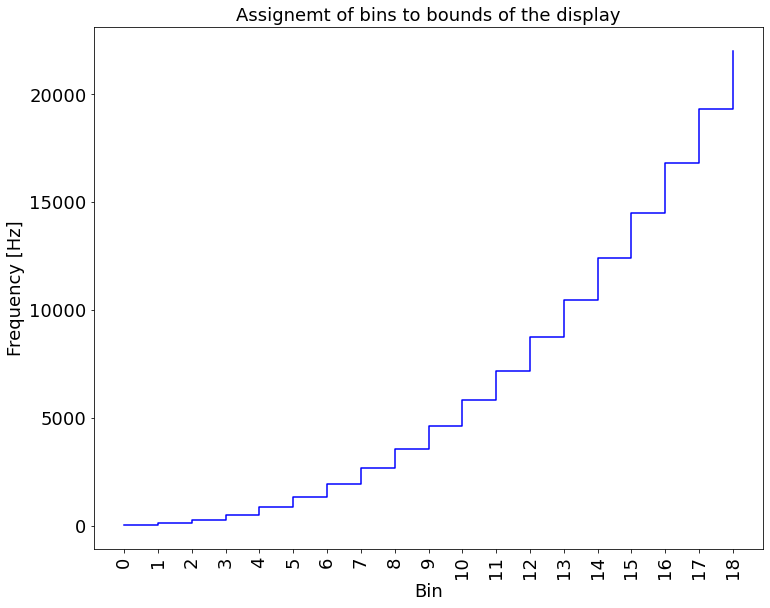

In [50]:
bins_assignment_k = 0.41 #0.45
bins = gen_bins(bands_count, samples_count // 2, bins_assignment_k)

resolution_width = sampling_frequency/2 / (samples_count // 2-1)
# print(f"Single resoolution width: {round(bin_width, 3)} Hz\n")

bins_count = dict(Counter(bins))
print("Number of bins per bound: ", bins_count, ", total: ", sum(bins_count.values()) , "\n")

plt.xticks(fontsize= 18, rotation=90)
plt.yticks(fontsize= 18)

ranges = [0]*bands_count

for idx in range(bands_count):
  band_width = bins_count[idx] * resolution_width
  ranges[idx] = ranges[idx - 1] + band_width if idx > 0 else band_width
  print(f"Bin {idx} from {round(ranges[idx] - band_width, 2)} Hz to {round(ranges[idx],2)} Hz, range: {round(band_width, 2)} Hz")

# plt.plot([str(bin) for bin in bins], samples_idx, 'r')
plt.step([str(bin) for bin in set(bins)], ranges, 'b', where='post')
plt.title('Assignemt of bins to bounds of the display', fontsize=18)
plt.ylabel('Frequency [Hz]', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.show()




# Audio Spectrum Display Visualization
Resulting values of the bandsare scaled to fit height of the display. In the target system there will be gaincontrol of the audio input signal. In software ther is clipping function so that the height won't exceed the display's dimensions.

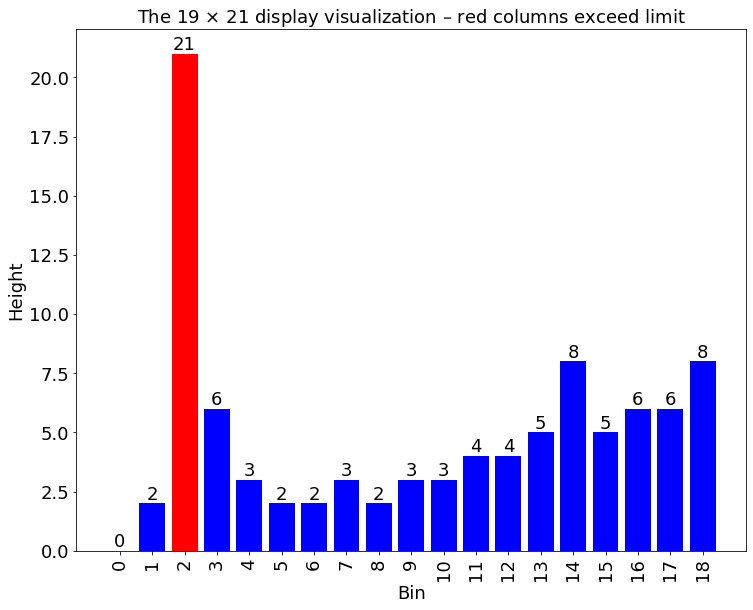

In [51]:
columns_values = [0]*bands_count
display_gain = 19
display_height = 21

for idx, mag in enumerate(mags):
  columns_values[bins[idx]] += mag

heights = [cv*display_gain for cv in columns_values]

colors = ['blue' if height_v < display_height else 'red' for height_v in heights]
heights = [round(min(height_v, display_height)) for height_v in heights]

bars = plt.bar([str(i) for i in range(bands_count)], heights, color=colors)

for rect in bars:
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), '%d' % int(rect.get_height()), ha='center', va='bottom', fontsize=18)

plt.xticks(fontsize= 18, rotation=90)
plt.yticks(fontsize= 18)
plt.title(f"The {bands_count} " + r"$\times$" + f" {display_height} display visualization – red columns exceed limit", fontsize=18)
plt.ylabel('Height', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.show()



## Output bins

In [52]:
variable_name_bins_count = "BINS_COUNT"
print(f"#define {variable_name_bins_count} {len(bins)}")
print(f"const int bins[{variable_name_bins_count}] = " + "{" + str(bins)[1:-1] + "};\n")

#define BINS_COUNT 1024
const int bins[BINS_COUNT] = {0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 

# Comparison datas

Time-based and frequency-based datas. Copy-paste to embedded system project.

In [53]:
variable_name_test_samples_count = "TEST_SAMPLES_COUNT"
print(f"// Data generated using Jupyter Notebook. The signal mixes {frequency_1} Hz, {frequency_2} Hz and white noise.")
print(f"#define {variable_name_test_samples_count} {len(val)}")

print(f"const float32_t test_signal[{variable_name_test_samples_count}] = " + "{" + str([round(v, 4) for v in val.astype('float32').tolist()])[1:-1] + "};\n")

// Data generated using Jupyter Notebook. The signal mixes 210 Hz, 12000.0 Hz and white noise.
#define TEST_SAMPLES_COUNT 2048
const float32_t test_signal[TEST_SAMPLES_COUNT] = {0.1133, 0.0425, -0.024, -0.0893, 0.1865, -0.0121, 0.1996, 0.0503, 0.2614, 0.1937, 0.2481, 0.08, 0.3051, 0.2263, 0.3135, 0.2752, 0.3807, 0.2346, 0.339, 0.507, 0.3528, 0.4439, 0.5177, 0.5795, 0.5312, 0.3823, 0.549, 0.52, 0.4721, 0.5626, 0.5939, 0.5827, 0.479, 0.5538, 0.6529, 0.6185, 0.4998, 0.7197, 0.8521, 0.6794, 0.6341, 0.6984, 0.6691, 0.763, 0.7202, 0.748, 0.7194, 0.8192, 0.7829, 0.8388, 0.7039, 0.6724, 0.7224, 0.7347, 0.6493, 0.7815, 0.8723, 0.7813, 0.6826, 0.8319, 0.7205, 0.7522, 0.7069, 0.748, 0.7526, 0.6072, 0.763, 0.8569, 0.8017, 0.4764, 0.5703, 0.6451, 0.5695, 0.6265, 0.6798, 0.4441, 0.463, 0.607, 0.621, 0.5499, 0.4129, 0.5063, 0.5342, 0.4202, 0.4024, 0.4866, 0.3617, 0.3259, 0.3613, 0.4909, 0.3808, 0.2376, 0.2835, 0.259, 0.2042, 0.173, 0.2284, 0.1887, 0.022, 0.1726, 0.1388, 0.1465, 0.0158, 0.1161, -0.016

In [54]:
print(len(v_4096.tolist() ))
print(f"const uint16_t ADC_SAMPLES[{'1024*2'}] = " + "{" + str([vv for vv in v_4096.tolist()])[1:-1] + "};\n")

2048
const uint16_t ADC_SAMPLES[1024*2] = {2279, 2134, 1998, 1864, 2429, 2022, 2456, 2150, 2582, 2444, 2555, 2211, 2672, 2510, 2689, 2610, 2827, 2527, 2741, 3085, 2769, 2956, 3107, 3233, 3135, 2830, 3171, 3112, 3014, 3199, 3263, 3240, 3028, 3181, 3384, 3313, 3070, 3521, 3792, 3438, 3345, 3477, 3417, 3609, 3522, 3579, 3520, 3724, 3650, 3764, 3488, 3424, 3526, 3551, 3376, 3647, 3833, 3647, 3445, 3750, 3522, 3587, 3494, 3579, 3588, 3290, 3609, 3801, 3689, 3022, 3215, 3368, 3213, 3330, 3439, 2956, 2995, 3290, 3319, 3173, 2892, 3084, 3141, 2907, 2871, 3043, 2788, 2714, 2787, 3052, 2827, 2534, 2627, 2577, 2465, 2401, 2515, 2433, 2092, 2400, 2331, 2347, 2079, 2285, 2013, 1929, 2004, 1921, 1884, 1689, 1580, 1945, 1787, 1385, 1748, 1482, 1402, 1150, 1749, 1502, 1199, 1195, 1620, 1492, 771, 1429, 1484, 1019, 781, 1284, 994, 701, 725, 1119, 931, 589, 959, 710, 751, 644, 807, 702, 635, 749, 849, 577, 456, 746, 707, 533, 403, 291, 719, 694, 573, 638, 435, 341, 584, 445, 309, 273, 692, 520, 455, 514

In [55]:
out_mags = np.abs(sig_fft_real + 1j*sig_fft_imag)
assert(len(out_mags) == len(val))
print(f"// Len of mags = {len(out_mags)} should be equal to len of time samples = {len(val)}. Use half.")
print(f"const float32_t test_megs[{variable_name_test_samples_count}] = " + "{" + str([round(mg, 4) for mg in out_mags.astype('float32').tolist()])[1:-1] + "};\n")

// Len of mags = 2048 should be equal to len of time samples = 2048. Use half.
const float32_t test_megs[TEST_SAMPLES_COUNT] = {9.1789, 21.1007, 22.1038, 26.136, 25.4541, 28.6199, 38.6152, 58.8647, 88.4298, 203.9201, 705.2682, 128.7262, 74.7142, 49.5909, 40.879, 34.3752, 31.5604, 20.3067, 19.2062, 18.4843, 16.8823, 14.5899, 14.4473, 11.5549, 12.8329, 13.6142, 9.0783, 10.1625, 10.5551, 14.2396, 9.5548, 9.6894, 9.4774, 9.6321, 6.4661, 4.0793, 8.8526, 7.5447, 6.5042, 8.99, 8.6224, 4.4419, 2.8322, 1.8984, 7.7419, 4.6664, 5.2807, 7.0892, 11.3039, 7.6152, 4.1893, 3.2688, 7.551, 4.0808, 6.4828, 2.2275, 4.4818, 7.1966, 1.6086, 6.46, 2.6526, 2.3265, 1.2124, 5.0767, 2.9113, 4.2899, 2.6247, 4.1576, 3.5057, 3.269, 0.1526, 3.2011, 2.1033, 5.3012, 6.6596, 4.9746, 1.9534, 9.9157, 5.3774, 0.9268, 4.7584, 1.058, 6.516, 2.2229, 4.8201, 4.5425, 4.8675, 3.9779, 5.871, 1.6767, 2.1291, 3.7111, 1.0715, 4.0198, 7.6556, 3.4175, 7.4126, 6.1839, 2.5456, 1.8327, 3.9464, 8.5081, 5.4142, 1.7006, 4.4266, 5.1682, 5.3

# IFFT check - frequency domain

The comparison of FFT evaluated using scipy and evaluated on embedded system.

Copy-paste 512 magnitudes, 1024 imaginary values and 1024 real parts. In CMSIS library input array is twice as long (2048) because of complex number representation. Resulting magnitudes buffer is 1024 long, but only half of it is used - 512 samples in total, representing frequencies from 0 to helf of sampling frequency (0-22kHz).

Time samples count: (2048,)
FFT output samples, real part count: (2048,)
FFT output samples, imaginary part count: (2048,)
To check rersults fill the arrays (of length 2048) from output of embedded system.
2048


ValueError: x and y must have same first dimension, but have shapes (1024,) and (512,)

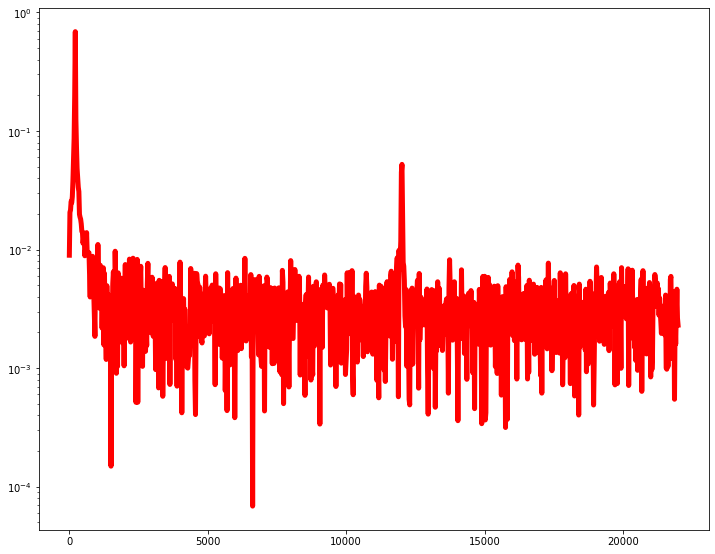

In [56]:
print(f"Time samples count: {t.shape}")
xf = sampling_frequency*np.arange(samples_count//2)/samples_count

print(f"FFT output samples, real part count: {sig_fft_real.shape}")
print(f"FFT output samples, imaginary part count: {sig_fft_imag.shape}")
sig_fft = sig_fft_real + 1j*sig_fft_imag
source_mags = 2.0/samples_count * np.abs(sig_fft_real + 1j*sig_fft_imag)[:samples_count//2]

print(f"To check rersults fill the arrays (of length {len(t)}) from output of embedded system.")

# Fill those arrays with readings, full length equal 'samples_count'
res_fft_real = np.array([-8.893, 6.500, 7.046, 6.170, 16.888, -129.514, -12.556, -4.873, -7.328, -3.493, -1.417, -0.140, -0.148, -1.226, 0.546, -1.925, 0.966, -1.938, 0.006, 0.362, -0.444, -1.652, 0.097, 0.929, 0.202, -2.169, -0.743, 2.183, 1.677, -0.063, -1.757, 0.024, -1.562, 1.860, -1.380, 1.450, 1.400, -1.405, 0.845, -4.213, -3.170, 1.671, 1.017, -0.755, 1.221, -2.025, 0.156, 0.008, 1.649, 1.898, 2.702, -2.900, 0.962, 2.059, -2.566, 0.666, -1.267, 0.257, -2.409, 2.431, 1.298, 0.675, 0.935, 0.703, -1.896, -0.660, 2.781, 1.203, -1.177, 1.126, -1.416, -1.125, 2.485, 0.075, 1.597, 0.912, -0.981, 2.071, -0.749, 0.898, 2.946, -1.428, 0.528, -0.459, 1.676, -0.479, -0.107, 0.881, 0.200, 0.779, 1.214, 2.063, 0.598, 2.854, 0.758, -1.182, -0.590, 0.712, 0.764, 0.311, -0.151, -0.338, 2.085, -1.196, -1.718, 2.636, 0.006, 2.820, 1.260, 0.946, 1.902, -0.257, 3.575, 0.386, 0.619, -1.809, -1.029, -0.547, -0.078, -1.043, 1.724, -0.474, 0.056, 3.015, 0.567, -1.671, 1.307, 1.655, 3.505, 3.149, -1.672, 1.770, 1.393, 1.778, 0.031, -0.605, 1.780, 2.303, 0.886, -1.011, 3.218, 1.567, 0.779, 1.759, -0.641, 0.358, -1.450, 0.849, -2.893, -1.740, 1.836, 0.699, 1.563, -3.216, 1.072, -1.349, -0.441, -0.023, -2.143, 2.130, -2.081, 0.154, 3.198, -1.308, -1.977, 0.741, 3.081, -0.579, -0.650, -1.131, 0.255, 1.174, 1.267, -1.214, -1.155, 0.317, -2.566, -0.389, 0.079, -4.570, -0.229, 2.124, 0.535, -0.399, 1.720, 0.515, 2.711, 0.621, 0.103, 0.327, -1.351, 1.846, 0.936, -1.188, -1.034, 1.931, 2.171, 0.309, -0.435, 3.130, -0.406, 4.300, 0.624, 0.184, -0.881, -1.566, -0.148, 1.200, 3.107, -0.516, 1.494, 1.546, 0.002, 4.163, 1.928, -0.099, 0.875, 1.482, -1.962, 1.385, -4.131, 3.162, -0.922, 0.085, 0.795, -0.588, 1.177, 2.197, 3.571, 1.547, -1.065, 0.318, -0.293, -0.348, 0.177, 1.566, -0.793, -0.848, 2.196, 2.004, 0.311, 1.789, 1.385, 3.120, 0.678, 0.497, 2.022, 0.027, -1.386, -2.819, 1.260, 2.061, 0.707, 1.293, -1.728, -1.912, 0.999, -4.232, -0.959, 2.241, -1.120, 1.417, 0.024, 0.727, 1.100, -1.644, -1.232, 3.008, 3.151, 1.668, 4.720, 1.141, -1.661, 1.607, 0.259, 5.481, 0.998, 4.215, 4.679, 25.924, -10.164, -2.117, -2.193, 0.359, -0.309, 0.183, 2.029, -1.350, 0.147, -2.437, -0.024, 2.812, 2.688, -1.242, 2.295, -0.193, -2.056, -0.982, 0.823, -0.712, -0.747, -0.890, -0.001, 2.691, 2.823, -3.013, 0.538, 1.845, -0.275, 3.058, 0.183, 0.602, -2.305, 0.205, -0.787, 0.821, 1.229, -1.204, 1.237, 2.069, -4.103, 0.142, -0.416, 0.608, -0.808, -0.915, 1.123, -1.224, 2.989, 2.577, -0.021, 3.067, -0.403, 2.649, 0.689, -0.650, 0.412, -1.184, -0.468, -0.333, -1.987, -0.914, -0.847, 1.007, -0.634, 0.441, -0.489, 1.205, 0.768, 1.826, -0.538, 2.518, 2.471, 1.244, -2.040, -0.489, -1.568, -1.448, -0.303, 0.846, -1.373, 0.157, 0.392, -1.028, 0.208, 0.082, 0.849, -1.539, 1.125, -2.079, -0.488, -1.596, 3.381, 0.807, -1.383, 2.203, 1.834, 1.092, 1.177, -0.328, -1.562, 0.372, 2.579, -0.021, 2.095, -0.763, 1.913, -1.722, 1.912, -0.621, 2.823, 0.761, 3.719, -2.486, -1.198, 0.602, -0.713, 2.261, -2.413, -1.360, 1.548, -0.015, -3.788, -0.446, -0.144, 0.628, 2.458, -1.406, -0.570, -1.652, -1.733, -1.970, -2.627, 1.714, 3.430, 0.723, -0.116, 2.852, -0.025, -0.121, -1.160, 0.283, -0.141, 1.012, 3.819, -1.159, -1.022, -0.166, -0.327, -0.476, 1.818, -1.954, 1.703, 2.509, 0.736, 0.048, 0.968, 0.702, 0.212, -0.299, -0.535, 0.358, -0.592, -1.294, 1.872, -0.270, -0.031, -4.050, -1.349, 1.355, -0.406, -0.835, -0.746, 2.559, 1.766, -4.229, 0.318, -1.884, 1.104, 1.305, 1.238, -2.415, 0.326, -0.015, -1.566, -1.504, 1.089, 1.926, -0.581, 1.339, 3.431, -1.889, -2.357, 0.528, 0.955, -0.615, 1.668, 1.303, -1.359, 3.709, -2.035, -0.807, 0.983, -2.400, 3.161, 0.830, 1.739, 1.169, 0.582, -0.192, -0.757, -0.974, 2.085, 2.661, -0.803, 2.957, 0.335, -0.657, 1.392, 1.224, 3.473, 2.200, 0.197, 0.221, 2.535, 1.281, 1.577, 0.179, 1.968, -0.500, 0.095, 4.118, 0.986, 4.118, 0.095, -0.500, 1.968, 0.179, 1.577, 1.281, 2.535, 0.221, 0.197, 2.200, 3.473, 1.224, 1.392, -0.657, 0.335, 2.957, -0.803, 2.661, 2.085, -0.974, -0.757, -0.192, 0.582, 1.169, 1.739, 0.830, 3.161, -2.400, 0.983, -0.807, -2.035, 3.709, -1.359, 1.303, 1.668, -0.615, 0.955, 0.528, -2.357, -1.889, 3.431, 1.339, -0.581, 1.926, 1.089, -1.504, -1.566, -0.015, 0.326, -2.415, 1.238, 1.305, 1.104, -1.884, 0.318, -4.229, 1.766, 2.559, -0.746, -0.835, -0.406, 1.355, -1.349, -4.050, -0.031, -0.270, 1.872, -1.294, -0.592, 0.358, -0.535, -0.299, 0.212, 0.702, 0.968, 0.048, 0.736, 2.509, 1.703, -1.954, 1.818, -0.476, -0.327, -0.166, -1.022, -1.159, 3.819, 1.012, -0.141, 0.283, -1.160, -0.121, -0.025, 2.852, -0.116, 0.723, 3.430, 1.714, -2.627, -1.970, -1.733, -1.652, -0.570, -1.406, 2.458, 0.628, -0.144, -0.446, -3.788, -0.015, 1.548, -1.360, -2.413, 2.261, -0.713, 0.602, -1.198, -2.486, 3.719, 0.761, 2.823, -0.621, 1.912, -1.722, 1.913, -0.763, 2.095, -0.021, 2.579, 0.372, -1.562, -0.328, 1.177, 1.092, 1.834, 2.203, -1.383, 0.807, 3.381, -1.596, -0.488, -2.079, 1.125, -1.539, 0.849, 0.082, 0.208, -1.028, 0.392, 0.157, -1.373, 0.846, -0.303, -1.448, -1.568, -0.489, -2.040, 1.244, 2.471, 2.518, -0.538, 1.826, 0.768, 1.205, -0.489, 0.441, -0.634, 1.007, -0.847, -0.914, -1.987, -0.333, -0.468, -1.184, 0.412, -0.650, 0.689, 2.649, -0.403, 3.067, -0.021, 2.577, 2.989, -1.224, 1.123, -0.915, -0.808, 0.608, -0.416, 0.142, -4.103, 2.069, 1.237, -1.204, 1.229, 0.821, -0.787, 0.205, -2.305, 0.602, 0.183, 3.058, -0.275, 1.845, 0.538, -3.013, 2.823, 2.691, -0.001, -0.890, -0.747, -0.712, 0.823, -0.982, -2.056, -0.193, 2.295, -1.242, 2.688, 2.812, -0.024, -2.437, 0.147, -1.350, 2.029, 0.183, -0.309, 0.359, -2.193, -2.117, -10.164, 25.924, 4.679, 4.215, 0.998, 5.481, 0.259, 1.607, -1.661, 1.141, 4.720, 1.668, 3.151, 3.008, -1.232, -1.644, 1.101, 0.727, 0.024, 1.417, -1.120, 2.241, -0.959, -4.232, 0.999, -1.912, -1.728, 1.293, 0.707, 2.061, 1.260, -2.819, -1.386, 0.027, 2.022, 0.497, 0.678, 3.120, 1.385, 1.789, 0.311, 2.004, 2.196, -0.848, -0.793, 1.566, 0.177, -0.348, -0.293, 0.318, -1.065, 1.547, 3.571, 2.197, 1.177, -0.588, 0.795, 0.085, -0.922, 3.162, -4.131, 1.385, -1.962, 1.482, 0.875, -0.099, 1.928, 4.163, 0.002, 1.546, 1.495, -0.516, 3.107, 1.200, -0.148, -1.566, -0.881, 0.184, 0.624, 4.300, -0.406, 3.130, -0.435, 0.309, 2.171, 1.931, -1.034, -1.188, 0.936, 1.846, -1.351, 0.327, 0.103, 0.621, 2.711, 0.515, 1.720, -0.399, 0.535, 2.124, -0.229, -4.570, 0.079, -0.389, -2.566, 0.317, -1.155, -1.214, 1.267, 1.174, 0.255, -1.131, -0.650, -0.579, 3.081, 0.741, -1.977, -1.308, 3.198, 0.154, -2.081, 2.130, -2.143, -0.023, -0.441, -1.349, 1.072, -3.216, 1.563, 0.699, 1.836, -1.740, -2.893, 0.849, -1.450, 0.358, -0.641, 1.759, 0.779, 1.567, 3.218, -1.011, 0.886, 2.303, 1.780, -0.605, 0.031, 1.778, 1.393, 1.770, -1.672, 3.149, 3.505, 1.655, 1.307, -1.671, 0.567, 3.015, 0.056, -0.474, 1.724, -1.043, -0.078, -0.547, -1.029, -1.809, 0.619, 0.386, 3.575, -0.257, 1.902, 0.946, 1.260, 2.820, 0.006, 2.636, -1.718, -1.196, 2.085, -0.338, -0.151, 0.311, 0.764, 0.712, -0.590, -1.182, 0.758, 2.854, 0.598, 2.063, 1.214, 0.779, 0.200, 0.881, -0.107, -0.479, 1.676, -0.459, 0.528, -1.428, 2.946, 0.898, -0.749, 2.071, -0.981, 0.912, 1.597, 0.075, 2.485, -1.125, -1.416, 1.126, -1.177, 1.203, 2.781, -0.660, -1.896, 0.703, 0.935, 0.675, 1.298, 2.431, -2.409, 0.257, -1.267, 0.666, -2.566, 2.059, 0.962, -2.900, 2.702, 1.898, 1.649, 0.008, 0.156, -2.025, 1.221, -0.755, 1.017, 1.671, -3.170, -4.213, 0.845, -1.405, 1.400, 1.450, -1.380, 1.860, -1.562, 0.024, -1.757, -0.063, 1.677, 2.183, -0.743, -2.169, 0.202, 0.929, 0.097, -1.652, -0.444, 0.362, 0.006, -1.938, 0.966, -1.925, 0.546, -1.226, -0.148, -0.140, -1.417, -3.493, -7.328, -4.873, -12.556, -129.514, 16.888, 6.170, 7.046, 6.500])

res_fft_imag = np.array([0.000, 2.470, 7.747, 16.105, 39.588, -360.543, -40.090, -22.077, -18.051, -12.913, -10.771, -9.125, -7.536, -5.402, -5.793, -4.787, -4.734, -6.017, -6.255, -2.479, -6.875, -1.896, -4.412, -3.892, -8.501, -1.325, -6.198, -2.976, -3.527, -1.203, -1.879, 0.630, -2.101, -4.149, -3.613, -0.549, -1.683, -0.745, -2.652, -1.105, -0.533, -2.268, -1.537, -3.289, -3.291, -1.441, 1.927, -3.839, -2.071, -2.552, -0.851, -4.688, -1.677, -4.929, -1.673, -3.261, -0.030, -4.209, -1.454, -4.613, -3.161, -0.363, -2.124, -2.556, 0.389, 0.518, -6.275, 1.516, -0.971, -3.811, 0.424, -1.696, -1.735, -3.131, 0.910, 0.745, -2.958, -0.223, 1.029, -0.266, 0.413, -1.165, 0.243, -2.062, 0.232, -2.888, 0.902, 1.641, -3.106, -1.068, -1.037, 1.229, 0.672, -5.828, -1.114, -0.768, -2.058, -0.784, 0.098, 0.615, 0.594, 0.980, -1.647, 0.230, 0.670, -2.282, 1.354, -0.589, -4.592, -2.451, 2.079, -1.079, -0.146, -2.473, -0.783, -2.363, 1.593, -0.831, -3.528, 1.489, -1.162, -1.362, 0.743, 1.231, 1.586, -2.170, -0.636, 1.360, -0.732, -0.439, 0.100, -0.047, 2.421, -2.838, 2.302, 0.144, 1.539, 0.236, -0.963, -0.166, -0.047, -1.966, -1.262, 2.139, 2.415, -0.506, 0.851, 0.943, -2.567, -0.318, -1.905, -0.327, 1.512, 0.628, 0.496, -3.245, -2.441, 0.485, -1.591, -0.658, -0.507, -0.766, 0.997, -2.896, 1.978, -1.985, 3.831, -0.912, -0.586, -1.555, -1.078, -0.168, 0.148, -2.651, -2.419, -2.406, -2.353, 1.204, -1.662, 3.906, -0.277, -1.043, -0.779, -0.849, -1.653, -1.236, -3.953, -3.114, -2.022, -1.654, 0.578, 0.750, -1.005, -0.937, -0.949, -0.838, 0.123, -1.952, -2.090, -1.756, -1.975, 3.030, -0.744, -2.325, 0.472, 0.813, 1.025, 4.050, 0.715, -2.061, 0.668, 1.498, 0.497, 1.911, 2.473, -1.874, -3.239, 0.483, 2.876, -1.732, -0.235, -0.688, -3.427, -2.580, -0.512, -1.075, 1.493, -3.797, 0.944, -1.895, 1.020, 0.893, -0.222, 1.248, -2.933, 3.333, -1.018, -2.393, -0.685, -0.776, -1.467, 0.352, -2.367, -1.601, -1.504, -0.207, -1.975, -1.034, 1.437, -0.538, -0.464, -1.444, -0.608, 0.772, 1.763, -1.945, 0.913, -0.152, 0.556, -1.050, 0.304, -1.663, -1.945, -1.233, -2.416, -0.584, -0.697, -1.663, -1.700, -2.324, -3.795, -0.275, 1.839, -2.136, -0.580, 0.609, -3.952, -2.968, -5.987, -19.907, 10.697, 1.664, 5.092, 0.279, 1.614, 2.301, 1.946, 0.025, -0.831, 1.014, -0.400, 1.012, 2.164, 1.820, -0.773, -0.053, -0.061, -0.287, 1.766, 4.036, 1.737, -1.363, -0.722, 0.289, -0.294, -1.542, -0.702, 3.656, 0.793, 1.900, -2.523, 2.218, -1.139, 1.228, -1.626, 1.065, 2.617, 0.625, 2.562, -0.365, -1.195, 1.372, 0.287, -1.150, -0.986, -3.591, 0.884, 0.176, 0.277, -2.571, 0.158, 0.074, 0.970, -0.110, -0.265, -0.399, -1.560, -0.953, 0.636, -1.745, -0.023, -1.945, 1.134, -2.889, -1.602, -0.247, 2.253, 2.768, -1.993, -1.597, -0.175, -0.378, -2.509, -1.677, 1.556, 3.678, -1.816, -4.076, 1.951, 0.238, -2.572, -2.010, 1.123, -0.733, -3.506, -1.002, 1.218, 2.511, -1.423, -1.825, -3.247, 1.140, -1.770, -1.419, 1.733, 1.153, 2.701, -1.436, -0.445, 0.083, -1.076, -1.337, 1.559, 0.857, -0.790, 1.485, 0.041, -1.894, -0.385, -0.137, -2.083, 1.194, -0.522, -0.954, 0.994, 0.175, 2.512, -1.277, 0.205, -1.148, 3.571, -1.335, 0.895, -1.610, -3.344, -0.625, -0.514, 1.336, -0.079, 0.216, -1.625, -0.471, -1.467, -0.059, -0.676, -0.329, 0.620, 0.972, -1.341, 2.152, 0.965, -1.413, 1.943, 0.811, 1.492, 0.954, 0.122, -0.688, 3.234, -0.818, -1.046, 2.330, 1.762, -0.088, -1.645, 2.453, 0.062, 0.398, -3.511, 0.086, 0.174, 0.981, 0.720, -1.912, 0.152, 1.454, 0.738, -0.113, -0.756, -1.252, 2.530, -1.211, -2.279, -0.020, 2.051, -1.934, 1.225, -0.290, -0.613, 0.461, -1.106, -1.651, -0.516, 2.294, 3.038, 0.598, -3.015, 1.962, 1.258, -0.094, -3.271, -0.113, -0.884, 4.170, 2.033, 0.282, 0.730, -1.869, 1.118, 2.216, 3.495, -2.162, 4.494, -1.809, 0.197, 0.062, -3.761, 4.319, 0.355, -0.886, 0.479, -0.777, 4.539, -1.442, 2.863, 3.688, -1.845, 0.377, 2.294, -0.547, 0.220, -0.784, 1.173, -0.486, 0.682, 4.178, -2.443, -2.287, -0.608, -0.848, -0.236, -0.670, 0.000, 0.670, 0.236, 0.848, 0.608, 2.287, 2.443, -4.178, -0.682, 0.486, -1.173, 0.784, -0.220, 0.547, -2.294, -0.377, 1.845, -3.688, -2.863, 1.442, -4.539, 0.777, -0.479, 0.886, -0.355, -4.319, 3.761, -0.062, -0.197, 1.809, -4.494, 2.162, -3.495, -2.216, -1.118, 1.869, -0.730, -0.282, -2.033, -4.170, 0.884, 0.113, 3.271, 0.094, -1.258, -1.962, 3.015, -0.598, -3.038, -2.294, 0.516, 1.651, 1.106, -0.461, 0.613, 0.290, -1.225, 1.934, -2.051, 0.020, 2.279, 1.211, -2.530, 1.252, 0.756, 0.113, -0.738, -1.454, -0.152, 1.912, -0.720, -0.981, -0.174, -0.086, 3.511, -0.398, -0.062, -2.453, 1.645, 0.088, -1.762, -2.330, 1.046, 0.818, -3.234, 0.688, -0.122, -0.954, -1.492, -0.811, -1.943, 1.413, -0.965, -2.152, 1.341, -0.972, -0.620, 0.329, 0.676, 0.059, 1.467, 0.471, 1.625, -0.216, 0.079, -1.336, 0.514, 0.625, 3.344, 1.610, -0.895, 1.335, -3.571, 1.148, -0.205, 1.277, -2.512, -0.175, -0.994, 0.954, 0.522, -1.194, 2.083, 0.137, 0.385, 1.894, -0.041, -1.485, 0.790, -0.857, -1.559, 1.337, 1.076, -0.083, 0.445, 1.436, -2.701, -1.153, -1.733, 1.419, 1.770, -1.140, 3.247, 1.825, 1.423, -2.511, -1.218, 1.002, 3.506, 0.733, -1.123, 2.010, 2.572, -0.238, -1.951, 4.076, 1.816, -3.678, -1.556, 1.677, 2.509, 0.378, 0.175, 1.597, 1.993, -2.768, -2.253, 0.247, 1.602, 2.889, -1.134, 1.945, 0.023, 1.745, -0.636, 0.953, 1.560, 0.399, 0.265, 0.110, -0.970, -0.074, -0.158, 2.571, -0.277, -0.176, -0.884, 3.591, 0.986, 1.150, -0.287, -1.372, 1.195, 0.365, -2.562, -0.625, -2.617, -1.065, 1.626, -1.228, 1.139, -2.218, 2.523, -1.900, -0.793, -3.656, 0.702, 1.542, 0.294, -0.289, 0.722, 1.363, -1.737, -4.036, -1.766, 0.287, 0.061, 0.053, 0.773, -1.820, -2.164, -1.012, 0.400, -1.014, 0.831, -0.025, -1.946, -2.301, -1.614, -0.279, -5.092, -1.664, -10.697, 19.907, 5.987, 2.968, 3.952, -0.609, 0.580, 2.136, -1.839, 0.275, 3.795, 2.324, 1.700, 1.663, 0.697, 0.584, 2.416, 1.233, 1.945, 1.663, -0.304, 1.050, -0.556, 0.152, -0.913, 1.945, -1.763, -0.772, 0.608, 1.444, 0.464, 0.538, -1.437, 1.034, 1.975, 0.207, 1.504, 1.601, 2.367, -0.352, 1.467, 0.776, 0.685, 2.393, 1.018, -3.333, 2.933, -1.248, 0.222, -0.893, -1.020, 1.895, -0.944, 3.797, -1.493, 1.075, 0.512, 2.580, 3.427, 0.688, 0.235, 1.732, -2.876, -0.483, 3.239, 1.874, -2.473, -1.911, -0.497, -1.498, -0.668, 2.061, -0.715, -4.050, -1.025, -0.813, -0.472, 2.325, 0.744, -3.030, 1.975, 1.756, 2.090, 1.952, -0.123, 0.838, 0.949, 0.937, 1.005, -0.750, -0.578, 1.654, 2.022, 3.114, 3.953, 1.236, 1.653, 0.849, 0.779, 1.043, 0.277, -3.906, 1.662, -1.204, 2.353, 2.406, 2.419, 2.651, -0.148, 0.168, 1.078, 1.555, 0.586, 0.912, -3.831, 1.985, -1.978, 2.896, -0.997, 0.766, 0.507, 0.658, 1.591, -0.485, 2.441, 3.245, -0.496, -0.628, -1.512, 0.327, 1.905, 0.318, 2.567, -0.943, -0.851, 0.506, -2.415, -2.139, 1.262, 1.966, 0.047, 0.166, 0.963, -0.236, -1.539, -0.144, -2.302, 2.838, -2.421, 0.047, -0.100, 0.439, 0.732, -1.360, 0.636, 2.170, -1.586, -1.231, -0.743, 1.362, 1.162, -1.489, 3.528, 0.831, -1.593, 2.363, 0.783, 2.473, 0.146, 1.079, -2.079, 2.451, 4.592, 0.589, -1.354, 2.282, -0.670, -0.230, 1.647, -0.980, -0.594, -0.615, -0.098, 0.784, 2.058, 0.768, 1.114, 5.828, -0.672, -1.229, 1.037, 1.068, 3.106, -1.641, -0.902, 2.888, -0.232, 2.062, -0.243, 1.165, -0.413, 0.266, -1.029, 0.223, 2.958, -0.745, -0.910, 3.131, 1.735, 1.696, -0.424, 3.811, 0.971, -1.516, 6.275, -0.518, -0.389, 2.556, 2.124, 0.363, 3.161, 4.613, 1.454, 4.209, 0.030, 3.261, 1.673, 4.929, 1.677, 4.688, 0.851, 2.552, 2.071, 3.839, -1.927, 1.441, 3.291, 3.289, 1.537, 2.268, 0.533, 1.105, 2.652, 0.745, 1.683, 0.549, 3.613, 4.149, 2.101, -0.630, 1.879, 1.203, 3.527, 2.976, 6.198, 1.325, 8.501, 3.892, 4.412, 1.896, 6.875, 2.479, 6.255, 6.017, 4.734, 4.787, 5.793, 5.402, 7.536, 9.125, 10.771, 12.913, 18.051, 22.077, 40.090, 360.543, -39.588, -16.105, -7.747, -2.470])

resulting_mags = 2.0/samples_count * np.array([8.893, 6.954, 10.472, 17.246, 43.039, 383.099, 42.010, 22.608, 19.481, 13.377, 10.864, 9.126, 7.537, 5.540, 5.819, 5.159, 4.832, 6.322, 6.255, 2.505, 6.889, 2.515, 4.413, 4.001, 8.503, 2.542, 6.242, 3.691, 3.905, 1.205, 2.572, 0.630, 2.618, 4.547, 3.868, 1.550, 2.189, 1.590, 2.783, 4.355, 3.214, 2.817, 1.843, 3.374, 3.510, 2.485, 1.934, 3.839, 2.647, 3.180, 2.833, 5.513, 1.934, 5.342, 3.063, 3.328, 1.268, 4.217, 2.814, 5.215, 3.417, 0.767, 2.321, 2.650, 1.935, 0.839, 6.863, 1.935, 1.526, 3.974, 1.478, 2.035, 3.031, 3.132, 1.838, 1.178, 3.116, 2.083, 1.273, 0.937, 2.975, 1.843, 0.581, 2.113, 1.692, 2.928, 0.909, 1.863, 3.112, 1.322, 1.597, 2.401, 0.900, 6.489, 1.347, 1.410, 2.141, 1.059, 0.770, 0.689, 0.613, 1.037, 2.657, 1.218, 1.844, 3.486, 1.354, 2.881, 4.762, 2.628, 2.818, 1.109, 3.578, 2.503, 0.998, 2.976, 1.897, 0.995, 3.529, 1.819, 2.079, 1.442, 0.745, 3.257, 1.685, 2.739, 1.454, 2.142, 3.580, 3.179, 1.675, 1.771, 2.793, 3.349, 2.303, 0.622, 2.353, 2.315, 1.308, 1.024, 3.218, 2.514, 1.483, 2.769, 2.499, 0.620, 1.681, 1.269, 3.868, 1.769, 2.646, 0.772, 2.175, 3.276, 1.181, 3.514, 2.481, 0.486, 2.669, 2.229, 2.141, 0.782, 3.350, 3.178, 2.797, 2.119, 4.917, 1.080, 0.875, 1.923, 1.108, 1.186, 1.276, 2.915, 2.680, 2.426, 3.482, 1.265, 1.664, 6.012, 0.359, 2.366, 0.945, 0.938, 2.386, 1.339, 4.794, 3.176, 2.025, 1.686, 1.470, 1.993, 1.374, 1.513, 1.404, 2.104, 2.175, 1.976, 2.135, 3.589, 2.016, 5.261, 0.971, 2.332, 0.999, 1.764, 1.036, 4.224, 3.189, 2.124, 1.637, 2.153, 0.497, 4.581, 3.136, 1.877, 3.355, 1.559, 3.481, 2.218, 4.137, 3.236, 3.549, 2.581, 0.946, 1.225, 1.901, 4.387, 3.694, 2.446, 1.474, 0.948, 0.367, 1.296, 2.938, 3.683, 1.291, 2.539, 2.300, 2.149, 1.500, 1.823, 2.743, 3.507, 1.650, 0.538, 2.827, 1.034, 1.996, 2.870, 1.343, 2.517, 0.933, 1.506, 2.469, 2.727, 1.353, 4.235, 1.108, 2.474, 1.160, 2.185, 1.945, 1.431, 2.655, 1.745, 1.416, 3.437, 3.580, 2.860, 6.056, 1.173, 2.478, 2.673, 0.635, 5.515, 4.076, 5.155, 7.598, 32.685, 14.756, 2.693, 5.544, 0.455, 1.644, 2.308, 2.811, 1.350, 0.844, 2.640, 0.401, 2.989, 3.451, 2.203, 2.422, 0.200, 2.057, 1.023, 1.949, 4.098, 1.891, 1.628, 0.722, 2.707, 2.839, 3.385, 0.885, 4.095, 0.840, 3.600, 2.529, 2.298, 2.571, 1.245, 1.807, 1.345, 2.891, 1.356, 2.845, 2.101, 4.274, 1.379, 0.506, 1.301, 1.275, 3.706, 1.429, 1.237, 3.001, 3.640, 0.159, 3.068, 1.050, 2.651, 0.738, 0.763, 1.613, 1.520, 0.790, 1.776, 1.987, 2.149, 1.415, 3.059, 1.723, 0.505, 2.305, 3.019, 2.136, 2.426, 0.565, 2.546, 3.522, 2.088, 2.565, 3.710, 2.399, 4.326, 1.974, 0.879, 2.916, 2.016, 1.190, 1.262, 3.512, 1.005, 1.485, 2.945, 1.814, 2.766, 3.283, 1.961, 3.816, 1.633, 2.217, 2.487, 3.265, 1.804, 1.258, 0.338, 1.896, 1.388, 3.014, 0.857, 2.240, 1.670, 1.914, 2.560, 1.950, 0.636, 3.508, 1.416, 3.756, 2.662, 1.557, 0.627, 2.611, 2.596, 2.422, 1.780, 3.892, 1.335, 3.892, 1.671, 3.348, 0.886, 2.511, 1.940, 0.576, 1.666, 2.376, 2.026, 3.009, 1.715, 3.496, 0.794, 0.630, 3.013, 1.341, 2.155, 1.509, 1.441, 1.948, 1.297, 4.100, 1.501, 1.029, 0.708, 3.250, 0.947, 2.098, 3.041, 2.451, 2.510, 1.802, 2.453, 0.970, 0.807, 3.518, 0.312, 0.563, 1.044, 0.932, 2.309, 1.878, 1.479, 0.738, 4.051, 1.546, 1.845, 2.563, 1.471, 2.398, 2.559, 2.707, 4.650, 1.265, 1.906, 1.263, 1.384, 1.660, 2.926, 0.610, 2.294, 3.418, 1.619, 3.206, 2.749, 1.385, 1.342, 4.740, 1.892, 2.517, 4.203, 2.246, 0.677, 1.820, 2.278, 1.760, 4.320, 4.044, 2.308, 4.601, 3.006, 3.167, 0.832, 4.144, 4.474, 0.681, 0.906, 0.896, 1.246, 4.995, 3.026, 2.973, 4.727, 1.876, 0.757, 2.683, 1.341, 3.480, 2.335, 1.190, 0.534, 2.625, 4.370, 2.907, 2.294, 2.060, 0.984, 0.254, 4.172, 0.986, 4.172, 0.254, 0.984, 2.060, 2.294, 2.907, 4.370, 2.625, 0.534, 1.190, 2.335, 3.480, 1.341, 2.683, 0.757, 1.876, 4.727, 2.973, 3.026, 4.995, 1.246, 0.896, 0.906, 0.681, 4.474, 4.144, 0.832, 3.167, 3.006, 4.601, 2.308, 4.044, 4.320, 1.760, 2.278, 1.820, 0.677, 2.246, 4.203, 2.517, 1.892, 4.740, 1.342, 1.385, 2.749, 3.206, 1.619, 3.418, 2.294, 0.610, 2.926, 1.660, 1.384, 1.263, 1.906, 1.265, 4.650, 2.707, 2.559, 2.398, 1.471, 2.563, 1.845, 1.546, 4.051, 0.738, 1.479, 1.878, 2.309, 0.932, 1.044, 0.563, 0.312, 3.518, 0.807, 0.970, 2.453, 1.802, 2.510, 2.451, 3.041, 2.098, 0.947, 3.250, 0.708, 1.029, 1.501, 4.100, 1.297, 1.948, 1.441, 1.509, 2.155, 1.341, 3.013, 0.630, 0.794, 3.496, 1.715, 3.009, 2.026, 2.376, 1.666, 0.576, 1.940, 2.511, 0.886, 3.348, 1.671, 3.892, 1.335, 3.892, 1.780, 2.422, 2.596, 2.611, 0.627, 1.557, 2.662, 3.756, 1.416, 3.508, 0.636, 1.950, 2.560, 1.914, 1.670, 2.240, 0.857, 3.014, 1.388, 1.896, 0.338, 1.258, 1.804, 3.265, 2.487, 2.217, 1.633, 3.816, 1.961, 3.283, 2.766, 1.814, 2.945, 1.485, 1.005, 3.512, 1.262, 1.190, 2.016, 2.916, 0.879, 1.974, 4.326, 2.399, 3.710, 2.565, 2.088, 3.522, 2.546, 0.565, 2.426, 2.136, 3.019, 2.305, 0.505, 1.723, 3.059, 1.415, 2.149, 1.987, 1.776, 0.790, 1.520, 1.613, 0.763, 0.738, 2.651, 1.050, 3.068, 0.159, 3.640, 3.001, 1.237, 1.429, 3.706, 1.275, 1.301, 0.506, 1.379, 4.274, 2.101, 2.845, 1.356, 2.891, 1.345, 1.807, 1.245, 2.571, 2.298, 2.529, 3.600, 0.840, 4.095, 0.885, 3.385, 2.839, 2.707, 0.722, 1.628, 1.891, 4.098, 1.949, 1.023, 2.057, 0.200, 2.422, 2.203, 3.451, 2.989, 0.401, 2.640, 0.844, 1.350, 2.811, 2.308, 1.644, 0.455, 5.544, 2.693, 14.756, 32.685, 7.598, 5.155, 4.076, 5.515, 0.635, 2.673, 2.478, 1.173, 6.056, 2.860, 3.580, 3.437, 1.416, 1.745, 2.655, 1.431, 1.945, 2.185, 1.160, 2.474, 1.108, 4.235, 1.353, 2.727, 2.469, 1.506, 0.933, 2.517, 1.343, 2.870, 1.996, 1.034, 2.827, 0.538, 1.650, 3.507, 2.743, 1.823, 1.500, 2.149, 2.300, 2.539, 1.291, 3.683, 2.938, 1.296, 0.367, 0.948, 1.474, 2.446, 3.694, 4.387, 1.901, 1.225, 0.946, 2.581, 3.549, 3.236, 4.137, 2.218, 3.481, 1.559, 3.355, 1.877, 3.136, 4.581, 0.497, 2.153, 1.637, 2.124, 3.189, 4.224, 1.036, 1.764, 0.999, 2.332, 0.971, 5.261, 2.016, 3.589, 2.135, 1.976, 2.175, 2.104, 1.404, 1.513, 1.374, 1.993, 1.470, 1.686, 2.025, 3.176, 4.794, 1.339, 2.386, 0.938, 0.945, 2.366, 0.359, 6.012, 1.664, 1.265, 3.482, 2.426, 2.680, 2.915, 1.276, 1.186, 1.108, 1.923, 0.875, 1.080, 4.917, 2.119, 2.797, 3.178, 3.350, 0.782, 2.141, 2.229, 2.669, 0.486, 2.481, 3.514, 1.181, 3.276, 2.175, 0.772, 2.646, 1.769, 3.868, 1.269, 1.681, 0.620, 2.499, 2.769, 1.483, 2.514, 3.218, 1.024, 1.308, 2.315, 2.353, 0.622, 2.303, 3.349, 2.793, 1.771, 1.675, 3.179, 3.580, 2.142, 1.454, 2.739, 1.685, 3.257, 0.745, 1.442, 2.079, 1.819, 3.529, 0.995, 1.897, 2.976, 0.998, 2.503, 3.578, 1.109, 2.818, 2.628, 4.762, 2.881, 1.354, 3.486, 1.844, 1.218, 2.657, 1.037, 0.613, 0.689, 0.770, 1.059, 2.141, 1.410, 1.347, 6.489, 0.900, 2.401, 1.597, 1.322, 3.112, 1.863, 0.909, 2.928, 1.692, 2.113, 0.581, 1.843, 2.975, 0.937, 1.273, 2.083, 3.116, 1.178, 1.838, 3.132, 3.031, 2.035, 1.478, 3.974, 1.526, 1.935, 6.863, 0.839, 1.935, 2.650, 2.321, 0.767, 3.417, 5.215, 2.814, 4.217, 1.268, 3.328, 3.063, 5.342, 1.934, 5.513, 2.833, 3.180, 2.647, 3.839, 1.934, 2.485, 3.510, 3.374, 1.843, 2.817, 3.214, 4.355, 2.783, 1.590, 2.189, 1.550, 3.868, 4.547, 2.618, 0.630, 2.572, 1.205, 3.905, 3.691, 6.242, 2.542, 8.503, 4.001, 4.413, 2.515, 6.889, 2.505, 6.255, 6.322, 4.832, 5.159, 5.819, 5.540, 7.537, 9.126, 10.864, 13.377, 19.481, 22.608, 42.010, 383.099, 43.039, 17.246, 10.472, 6.954][:512])
print(samples_count)
# plt.xscale("log")
plt.yscale("log")
plt.plot(xf, source_mags, 'r', label='source signal', linewidth=5)
plt.plot(xf, resulting_mags, '--' ,color='b', label='resulting signal', linewidth=2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
# plt.axvline(x=frequency_1, c="brown")
# plt.axvline(x=frequency_2, c="brown")
plt.text(frequency_1, 1e-3, f"{frequency_1} Hz", fontsize = 23, rotation=85)
plt.text(frequency_2, 1e-3, f"{frequency_2} Hz", fontsize = 23, rotation=85)
plt.xlabel("Frequency f[Hz]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal vs FFT results from embedded system', fontsize=18)
plt.legend(fontsize=18)
plt.show()



# IFFT check - time domain

To recreate time-based signal both imaginary and real parts of output FFT are needed. Original signal is compared with the signal reconstruction using scipy.

In [ ]:
res_fft_cplx = res_fft_real + 1j*res_fft_imag

s = np.fft.ifft(res_fft_cplx)
plt.plot(t*1000, val, label='source', color='r', linewidth=5)
plt.plot(t*1000, s.real, '--', label='iFFT', color='b', linewidth=2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.legend(fontsize=18)
plt.xlabel("Time t[ms]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title("Input signal vs signal reconstructed from FFT", fontsize=18)
plt.show()

zoom_range = len(t)//16
plt.plot(t[:zoom_range]*1e6, val[:zoom_range], label='source', color='r', linewidth=5)
plt.plot(t[:zoom_range]*1e6, s.real[:zoom_range], '--', label='iFFT', color='b', linewidth=2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.legend(fontsize=18)
plt.xlabel(r"Time t[$\mu s$]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title("Input signal vs signal reconstructed from FFT (zoom in)", fontsize=18)
plt.show()

# References

How to use STM32 CMSIS FFT library in STM32CubeIDE's project: 
https://community.st.com/s/article/configuring-dsp-libraries-on-stm32cubeide

Documentation https://www.keil.com/pack/doc/CMSIS/DSP/html/group__ComplexFFT.html

STM32F303VCT6 https://www.st.com/en/microcontrollers-microprocessors/stm32f303vc.html
STM32F446RET6 https://www.st.com/en/microcontrollers-microprocessors/stm32f446re.html


## Comparison and sympulation
Noise can be removed with simple thresholding before adding by using bins-bounds LUT.

Warning! Now sampling frequency (measured) is 45.73 kHz because hardware ADC implementation using DMA in circular mode. If not taken into account there will be visible shift in higher frequencies.

In theory sampling frequency should be:
- resolution 12b thus 15 clock cycles per convertion
- sampling time = 480 clock cycles
- ADC1-3 clk f from APB2_peripheral = 90MHz
- clock divider = 4

Resulting theoretical sampling frequency = 45.45455kHz


![Clocks](adc_clocks.JPG)

In [ ]:
sampling_frequency = 45.73e3
xf = sampling_frequency*np.arange(samples_count)/samples_count
freqs = xf[:samples_count//2]

In [ ]:

data = [0.017, 0.014, 0.020, 0.034, 0.084, 0.748, 0.082, 0.044, 0.038, 0.026, 0.021, 0.018, 0.015, 0.011, 0.011, 0.010, 0.009, 0.012, 0.012, 0.005, 0.013, 0.005, 0.009, 0.008, 0.017, 0.005, 0.012, 0.007, 0.008, 0.002, 0.005, 0.001, 0.005, 0.009, 0.008, 0.003, 0.004, 0.003, 0.005, 0.009, 0.006, 0.006, 0.004, 0.007, 0.007, 0.005, 0.004, 0.007, 0.005, 0.006, 0.006, 0.011, 0.004, 0.010, 0.006, 0.007, 0.002, 0.008, 0.005, 0.010, 0.007, 0.001, 0.005, 0.005, 0.004, 0.002, 0.013, 0.004, 0.003, 0.008, 0.003, 0.004, 0.006, 0.006, 0.004, 0.002, 0.006, 0.004, 0.002, 0.002, 0.006, 0.004, 0.001, 0.004, 0.003, 0.006, 0.002, 0.004, 0.006, 0.003, 0.003, 0.005, 0.002, 0.013, 0.003, 0.003, 0.004, 0.002, 0.002, 0.001, 0.001, 0.002, 0.005, 0.002, 0.004, 0.007, 0.003, 0.006, 0.009, 0.005, 0.006, 0.002, 0.007, 0.005, 0.002, 0.006, 0.004, 0.002, 0.007, 0.004, 0.004, 0.003, 0.001, 0.006, 0.003, 0.005, 0.003, 0.004, 0.007, 0.006, 0.003, 0.003, 0.005, 0.007, 0.004, 0.001, 0.005, 0.005, 0.003, 0.002, 0.006, 0.005, 0.003, 0.005, 0.005, 0.001, 0.003, 0.002, 0.008, 0.003, 0.005, 0.002, 0.004, 0.006, 0.002, 0.007, 0.005, 0.001, 0.005, 0.004, 0.004, 0.002, 0.007, 0.006, 0.005, 0.004, 0.010, 0.002, 0.002, 0.004, 0.002, 0.002, 0.002, 0.006, 0.005, 0.005, 0.007, 0.002, 0.003, 0.012, 0.001, 0.005, 0.002, 0.002, 0.005, 0.003, 0.009, 0.006, 0.004, 0.003, 0.003, 0.004, 0.003, 0.003, 0.003, 0.004, 0.004, 0.004, 0.004, 0.007, 0.004, 0.010, 0.002, 0.005, 0.002, 0.003, 0.002, 0.008, 0.006, 0.004, 0.003, 0.004, 0.001, 0.009, 0.006, 0.004, 0.007, 0.003, 0.007, 0.004, 0.008, 0.006, 0.007, 0.005, 0.002, 0.002, 0.004, 0.009, 0.007, 0.005, 0.003, 0.002, 0.001, 0.003, 0.006, 0.007, 0.003, 0.005, 0.004, 0.004, 0.003, 0.004, 0.005, 0.007, 0.003, 0.001, 0.006, 0.002, 0.004, 0.006, 0.003, 0.005, 0.002, 0.003, 0.005, 0.005, 0.003, 0.008, 0.002, 0.005, 0.002, 0.004, 0.004, 0.003, 0.005, 0.003, 0.003, 0.007, 0.007, 0.006, 0.012, 0.002, 0.005, 0.005, 0.001, 0.011, 0.008, 0.010, 0.015, 0.064, 0.029, 0.005, 0.011, 0.001, 0.003, 0.005, 0.005, 0.003, 0.002, 0.005, 0.001, 0.006, 0.007, 0.004, 0.005, 0.000, 0.004, 0.002, 0.004, 0.008, 0.004, 0.003, 0.001, 0.005, 0.006, 0.007, 0.002, 0.008, 0.002, 0.007, 0.005, 0.004, 0.005, 0.002, 0.004, 0.003, 0.006, 0.003, 0.006, 0.004, 0.008, 0.003, 0.001, 0.003, 0.002, 0.007, 0.003, 0.002, 0.006, 0.007, 0.000, 0.006, 0.002, 0.005, 0.001, 0.001, 0.003, 0.003, 0.002, 0.003, 0.004, 0.004, 0.003, 0.006, 0.003, 0.001, 0.005, 0.006, 0.004, 0.005, 0.001, 0.005, 0.007, 0.004, 0.005, 0.007, 0.005, 0.008, 0.004, 0.002, 0.006, 0.004, 0.002, 0.002, 0.007, 0.002, 0.003, 0.006, 0.004, 0.005, 0.006, 0.004, 0.007, 0.003, 0.004, 0.005, 0.006, 0.004, 0.002, 0.001, 0.004, 0.003, 0.006, 0.002, 0.004, 0.003, 0.004, 0.005, 0.004, 0.001, 0.007, 0.003, 0.007, 0.005, 0.003, 0.001, 0.005, 0.005, 0.005, 0.003, 0.008, 0.003, 0.008, 0.003, 0.007, 0.002, 0.005, 0.004, 0.001, 0.003, 0.005, 0.004, 0.006, 0.003, 0.007, 0.002, 0.001, 0.006, 0.003, 0.004, 0.003, 0.003, 0.004, 0.003, 0.008, 0.003, 0.002, 0.001, 0.006, 0.002, 0.004, 0.006, 0.005, 0.005, 0.004, 0.005, 0.002, 0.002, 0.007, 0.001, 0.001, 0.002, 0.002, 0.005, 0.004, 0.003, 0.001, 0.008, 0.003, 0.004, 0.005, 0.003, 0.005, 0.005, 0.005, 0.009, 0.002, 0.004, 0.002, 0.003, 0.003, 0.006, 0.001, 0.004, 0.007, 0.003, 0.006, 0.005, 0.003, 0.003, 0.009, 0.004, 0.005, 0.008, 0.004, 0.001, 0.004, 0.004, 0.003, 0.008, 0.008, 0.005, 0.009, 0.006, 0.006, 0.002, 0.008, 0.009, 0.001, 0.002, 0.002, 0.002, 0.010, 0.006, 0.006, 0.009, 0.004, 0.001, 0.005, 0.003, 0.007, 0.005, 0.002, 0.001, 0.005, 0.009, 0.006, 0.004, 0.004, 0.002, 0.000, 0.008]

plt.plot(freqs, data, linewidth=3)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.text(frequency_1, 1e-3, f"{frequency_1} Hz", fontsize = 23, rotation=85)
plt.text(frequency_2, 1e-3, f"{frequency_2} Hz", fontsize = 23, rotation=85)
plt.xlabel("Frequency f[Hz]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal', fontsize=18)
plt.show()

# todo
plt.yscale("log")
plt.hist(data, bins=100)
plt.show()

## Results comparison

In [ ]:
# columns_values = [1.099, 0.364, 0.207, 0.137, 0.120, 0.117, 0.124, 0.091, 0.109, 0.123, 0.132, 0.156, 0.173, 0.167, 0.191, 0.187, 0.206, 0.211, 0.389]
columns_values = [0.017, 0.034, 0.866, 0.229, 0.086, 0.091, 0.076, 0.110, 0.088, 0.088, 0.131, 0.136, 0.148, 0.189, 0.300, 0.195, 0.223, 0.223, 0.296]

display_gain = 25
display_height = 21

# for idx, mag in enumerate(mags):
#   columns_values[bins[idx]] += mag

heights = [cv*display_gain for cv in columns_values]

colors = ['blue' if height_v < display_height else 'red' for height_v in heights]
heights = [round(min(height_v, display_height)) for height_v in heights]

bars = plt.bar([str(i) for i in range(bands_count)], heights, color=colors)

for rect in bars:
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), '%d' % int(rect.get_height()), ha='center', va='bottom', fontsize=18)

plt.xticks(fontsize= 18, rotation=90)
plt.yticks(fontsize= 18)
plt.title(f"The {bands_count} " + r"$\times$" + f" {display_height} display visualization – red columns exceed limit", fontsize=18)
plt.ylabel('Height', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.show()

## Noise removal
Values below about 0.05 can be thresholded
```c
static void mags_to_bounds() {
	for(int i = 0; i < 19; i++)
		bounds_heights[i] = 0;

	for(int i = 0; i < 512; i++) {
		if(usable_magnitudes[i] > 0.025)
			bounds_heights[bins[i]] += usable_magnitudes[i];
	}
}
```


In [ ]:
columns_values_thres = [0.000, 0.020, 0.866, 0.212, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.093, 0.000, 0.000, 0.000, 0.000]

display_gain = 25
display_height = 21

# for idx, mag in enumerate(mags):
#   columns_values_thres[bins[idx]] += mag

heights = [cv*display_gain for cv in columns_values_thres]

colors = ['blue' if height_v < display_height else 'red' for height_v in heights]
heights = [round(min(height_v, display_height)) for height_v in heights]

bars = plt.bar([str(i) for i in range(bands_count)], heights, color=colors)

for rect in bars:
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), '%d' % int(rect.get_height()), ha='center', va='bottom', fontsize=18)

plt.xticks(fontsize= 18, rotation=90)
plt.yticks(fontsize= 18)
plt.title(f"The {bands_count} " + r"$\times$" + f" {display_height} display visualization – red columns exceed limit", fontsize=18)
plt.ylabel('Height', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.show()

In [ ]:
columns_values_thres = [0.017, 0.034, 0.866, 0.229, 0.072, 0.042, 0.000, 0.031, 0.013, 0.013, 0.000, 0.000, 0.022, 0.000, 0.151, 0.000, 0.000, 0.000, 0.000,]

display_gain = 28
display_height = 21

# for idx, mag in enumerate(mags):
#   columns_values_thres[bins[idx]] += mag

heights = [cv*display_gain for cv in columns_values_thres]

colors = ['blue' if height_v < display_height else 'red' for height_v in heights]
heights = [round(min(height_v, display_height)) for height_v in heights]

bars = plt.bar([str(i) for i in range(bands_count)], heights, color=colors)

for rect in bars:
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), '%d' % int(rect.get_height()), ha='center', va='bottom', fontsize=18)

plt.xticks(fontsize= 18, rotation=90)
plt.yticks(fontsize= 18)
plt.title(f"The {bands_count} " + r"$\times$" + f" {display_height} display visualization – red columns exceed limit", fontsize=18)
plt.ylabel('Height', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.show()

## Test signal - results

Seems working. 2 spikes are clearly visible.
Checkpoint: [source code in zip](Example_1_testsignal_FFT.zip)

## Testing with DAC

Now there will be done test using built in DAC. Sine wave will ge ganeretad and output with DAC to get 1kHz.
Check another notebook with [Sine Generation](../ASD_STM32F4/Notebooks/ASD_sine_generator.ipynb)

![128 DAC samples](../ASD_STM32F4/Notebooks/samples_128.png)

Resulting 2kHz signal with RC filter (_---->>>> todo values):

![128 DAC signal](DAC_2kHz/SDS00084.BMP)

![128 DAC signal](DAC_2kHz/SDS00085.BMP)

Some unevenness can be seen. It could be improved with variable value change step as derivative of sine (cosine).

![128 DAC signal](DAC_2kHz/SDS00083.BMP)

## Aquiring DAC with ADC and process - comparison

Colected samples from ADC and FFT results

In [ ]:
test_freq = 2e3

signal_half_buffer_adc_from_dac = np.array([3164, 3547, 3815, 3957, 3948, 3802, 3524, 3139, 2668, 2157, 1637, 1145, 725, 402, 202, 128, 215, 431, 776, 1209, 1712, 2236, 2748, 3215, 3581, 3837, 3960, 3938, 3773, 3487, 3089, 2617, 2104, 1579, 1101, 686, 377, 193, 128, 232, 464, 815, 1261, 1765, 2290, 2802, 3251, 3614, 3854, 3963, 3926, 3751, 3447, 3045, 2565, 2047, 1532, 1051, 647, 350, 181, 128, 251, 500, 858, 1312, 1818, 2349, 2850, 3298, 3644, 3873, 3966, 3916, 3722, 3412, 2998, 2509, 1994, 1475, 1004, 613, 328, 171, 135, 270, 529, 905, 1361, 1878, 2402, 2906, 3340, 3675, 3888, 3968, 3898, 3692, 3371, 2943, 2459, 1934, 1424, 960, 576, 303, 165, 146, 291, 564, 945, 1420, 1929, 2460, 2953, 3378, 3703, 3901, 3968, 3886, 3672, 3330, 2899, 2399, 1880, 1373, 910, 544, 284, 154, 157, 315, 598, 994, 1467, 1989, 2512, 2999, 3420, 3730, 3916, 3966, 3870, 3638, 3292, 2848, 2347, 1827, 1320, 872, 507, 264, 146, 171, 338, 637, 1039, 1524, 2054, 2565, 3051, 3454, 3752, 3921, 3962, 3850, 3608, 3247, 2798, 2295, 1768, 1272, 825, 477, 246, 140, 180, 368, 672, 1090, 1577, 2101, 2621, 3095, 3494, 3781, 3943, 3958, 3833, 3571, 3202, 2744, 2235, 1720, 1219, 784, 441, 227, 135, 195, 392, 715, 1137, 1630, 2156, 2671, 3145, 3530, 3805, 3948, 3951, 3806, 3539, 3157, 2700, 2186, 1661, 1169, 745, 414, 212, 128, 205, 421, 754, 1185, 1687, 2208, 2727, 3188, 3566, 3825, 3954, 3943, 3786, 3504, 3113, 2645, 2126, 1609, 1120, 702, 388, 198, 128, 225, 450, 795, 1238, 1739, 2268, 2775, 3232, 3598, 3844, 3959, 3932, 3758, 3466, 3067, 2587, 2073, 1554, 1072, 666, 362, 187, 127, 243, 480, 840, 1286, 1801, 2322, 2829, 3275, 3632, 3864, 3964, 3919, 3736, 3432, 3025, 2537, 2009, 1500, 1030, 627, 338, 177, 131, 261, 521, 880, 1341, 1852, 2372, 2881, 3314, 3663, 3880, 3966, 3906, 3711, 3389, 2970, 2486, 1960, 1449, 977, 592, 314, 166, 141, 283, 548, 937, 1390, 1906, 2433, 2930, 3363, 3689, 3896, 3968, 3892, 3681, 3352, 2919, 2427, 1910, 1393, 935, 556, 292, 156, 153, 303, 584, 972, 1443, 1963, 2487, 2981, 3400, 3720, 3915, 3963, 3876, 3654, 3309, 2870, 2376, 1849, 1345, 890, 522, 272, 149, 163, 328, 620, 1015, 1499, 2016, 2543, 3027, 3440, 3744, 3924, 3965, 3858, 3622, 3268, 2824, 2316, 1798, 1295, 847, 490, 252, 142, 175, 349, 654, 1069, 1550, 2076, 2594, 3076, 3476, 3769, 3930, 3963, 3838, 3588, 3224, 2768, 2264, 1741, 1241, 805, 457, 235, 136, 189, 379, 696, 1112, 1611, 2129, 2649, 3125, 3511, 3793, 3944, 3951, 3819, 3556, 3178, 2725, 2208, 1686, 1195, 764, 428, 220, 132, 204, 407, 732, 1165, 1660, 2187, 2702, 3168, 3549, 3815, 3950, 3944, 3800, 3520, 3135, 2665, 2152, 1636, 1142, 722, 401, 209, 128, 218, 433, 778, 1212, 1714, 2242, 2753, 3216, 3582, 3837, 3956, 3936, 3773, 3484, 3087, 2612, 2098, 1578, 1097, 681, 375, 195, 128, 233, 467, 818, 1264, 1773, 2294, 2811, 3262, 3616, 3855, 3961, 3923, 3748, 3443, 3042, 2562, 2039, 1527, 1044, 644, 350, 180, 130, 253, 498, 862, 1317, 1819, 2353, 2857, 3301, 3648, 3867, 3966, 3915, 3720, 3408, 2994, 2504, 1988, 1472, 999, 611, 324, 169, 138, 272, 532, 904, 1362, 1882, 2407, 2908, 3342, 3675, 3890, 3967, 3898, 3695, 3370, 2944, 2452, 1930, 1421, 954, 573, 302, 160, 148, 294, 566, 948, 1423, 1936, 2461, 2956, 3381, 3706, 3904, 3968, 3883, 3666, 3328, 2896, 2397, 1877, 1370, 908, 539, 280, 153, 157, 316, 602, 1001, 1470, 1990, 2517, 3002, 3422, 3732, 3916, 3967, 3868, 3634, 3284, 2843, 2341, 1823, 1317, 869, 504, 261, 146, 173, 338, 644, 1043, 1526, 2049, 2569, 3056, 3460, 3758, 3930, 3964, 3854, 3604, 3234, 2793, 2291, 1766, 1268, 823, 472, 243, 140, 181, 368, 676, 1091, 1584, 2101, 2628, 3100, 3495, 3783, 3937, 3957, 3829, 3567, 3200, 2744, 2230, 1716, 1210, 781, 443, 226, 134, 196, 393, 717, 1142, 1633, 2163, 2678, 3148, 3532, 3807, 3947, 3949, 3803, 3537, 3155, 2688, 2184, 1658, 1166, 742, 413, 212, 130, 210, 421, 757, 1188, 1692, 2214, 2730, 3192, 3566, 3824, 3955, 3941, 3784, 3500, 3106, 2641, 2122, 1604, 1118, 698, 386, 198, 129, 226, 454, 796, 1241, 1744, 2275, 2781, 3235, 3601, 3852, 3960, 3930, 3760, 3463, 3064, 2583, 2069, 1552, 1068, 662, 360, 182, 129, 244, 483, 844, 1292, 1802, 2326, 2832, 3280, 3633, 3865, 3965, 3920, 3733, 3426, 3016, 2531, 2014, 1496, 1025, 624, 336, 176, 131, 262, 517, 884, 1348, 1856, 2380, 2885, 3320, 3665, 3884, 3967, 3905, 3709, 3384, 2967, 2477, 1953, 1449, 976, 589, 311, 166, 142, 284, 550, 931, 1396, 1913, 2437, 2933, 3364, 3691, 3896, 3969, 3892, 3680, 3348, 2917, 2422, 1905, 1393, 931, 553, 290, 154, 154, 305, 589, 976, 1447, 1972, 2491, 2984, 3404, 3722, 3911, 3966, 3874, 3648, 3309, 2865, 2372, 1845, 1340, 887, 519, 272, 150, 164, 329, 623, 1019, 1504, 2020, 2546, 3028, 3440, 3746, 3919, 3960, 3854, 3619, 3266, 2818, 2313, 1793, 1282, 842, 489, 253, 138, 177, 354, 659, 1074, 1555, 2080, 2600, 3079, 3481, 3773, 3935, 3960, 3838, 3584, 3221, 2763, 2262, 1740, 1237, 803, 456, 233, 135, 190, 380, 701, 1116, 1612, 2134, 2652, 3127, 3516, 3793, 3944, 3953, 3817, 3552, 3173, 2716, 2206, 1681, 1192, 758, 427, 219, 131, 203, 409, 736, 1170, 1662, 2189, 2706, 3168, 3554, 3822, 3951, 3944, 3796, 3515, 3130, 2664, 2148, 1634, 1137, 720, 400, 203, 128, 219, 441, 780, 1217, 1719, 2247, 2757, 3218, 3585, 3835, 3957, 3936, 3771, 3480, 3082, 2608, 2098, 1574, 1094, 680, 373, 192, 128, 235, 470, 824, 1268, 1774, 2299, 2811, 3260, 3618, 3857, 3964, 3924, 3748, 3444, 3036, 2560, 2036, 1523, 1042, 642, 347, 180, 126, 256, 500, 868, 1321, 1828, 2360, 2860, 3304, 3652, 3874, 3967, 3911, 3717, 3400, 2990, 2498, 1983, 1470, 995, 608, 321, 169, 136, 273, 533, 909, 1370, 1888, 2411, 2910, 3346, 3678, 3890, 3972, 3897, 3693, 3368, 2938, 2451, 1927, 1415, 953, 568, 303, 160, 147, 295, 570, 951, 1426, 1941, 2466, 2960, 3384, 3708, 3904, 3965, 3880, 3664, 3322, 2892, 2395, 1872, 1368, 906, 539, 281, 152, 159, 318, 604, 995, 1474, 1998, 2521, 3007, 3426, 3733, 3917, 3966, 3866, 3632, 3284, 2838, 2336, 1820, 1313, 864, 502, 259, 145, 168])
signal_half_buffer_adc_from_dac = (2.0 * signal_half_buffer_adc_from_dac / 4095) - 1.0
signal_half_buffer_adc_from_dac = signal_half_buffer_adc_from_dac.tolist()

plt.plot(t*1000, signal_half_buffer_adc_from_dac)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.xlabel("Time t[ms]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title(f"DAC read by ADC - frequency 2kHz, t = 0.5 ms", fontsize=18)
plt.show()
    
max_val = max(signal_half_buffer_adc_from_dac)
start_idx = signal_half_buffer_adc_from_dac.index(max_val)
samples = 50
    
plt.plot(t[start_idx:start_idx+part]*1000, signal_half_buffer_adc_from_dac[start_idx:start_idx+part])
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.xlabel("Time t[ms]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title(f"DAC read by ADC - frequency 2kHz, t = 0.5 ms", fontsize=18)
plt.show()

In [ ]:
mags_adc_from_dac = [0.008, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.005, 0.005, 0.005, 0.005, 0.005, 0.006, 0.006, 0.006, 0.007, 0.007, 0.007, 0.008, 0.008, 0.009, 0.009, 0.010, 0.011, 0.011, 0.012, 0.013, 0.014, 0.016, 0.017, 0.019, 0.021, 0.024, 0.027, 0.032, 0.037, 0.046, 0.058, 0.081, 0.128, 0.308, 0.827, 0.179, 0.101, 0.071, 0.055, 0.044, 0.038, 0.033, 0.029, 0.026, 0.024, 0.022, 0.020, 0.019, 0.017, 0.016, 0.016, 0.015, 0.014, 0.013, 0.013, 0.012, 0.012, 0.011, 0.011, 0.010, 0.010, 0.010, 0.009, 0.009, 0.009, 0.009, 0.008, 0.008, 0.008, 0.008, 0.008, 0.007, 0.007, 0.007, 0.007, 0.007, 0.006, 0.006, 0.005, 0.008, 0.007, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.003, 0.004, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.003, 0.003, 0.002, 0.002, 0.003, 0.003, 0.002, 0.002, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.002, 0.001, 0.002, 0.002, 0.001, 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.002, 0.001, 0.002, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
test_freq = 2e3
plt.plot(freqs, mags_adc_from_dac, linewidth=3)
# plt.xscale("log")
# plt.yscale("log")
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.text(test_freq, 1e-3, f"{test_freq} Hz", fontsize = 23, rotation=85)
plt.axvline(x=test_freq, c="brown")
plt.xlabel("Frequency f[Hz]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal', fontsize=18)
plt.show()

## Signal reconstruction

In [ ]:
real_adc_from_dac = [4.052, 1.917, 1.896, 1.923, 1.894, 1.944, 1.940, 1.988, 1.942, 1.967, 1.973, 1.998, 2.020, 2.021, 2.039, 2.080, 2.100, 2.143, 2.127, 2.200, 2.218, 2.280, 2.336, 2.329, 2.404, 2.468, 2.559, 2.622, 2.699, 2.808, 2.952, 3.024, 3.191, 3.403, 3.625, 3.906, 4.217, 4.577, 5.119, 5.844, 6.878, 8.382, 11.083, 16.909, 38.779, -99.723, -20.590, -11.093, -7.400, -5.419, -4.241, -3.436, -2.813, -2.348, -2.018, -1.718, -1.486, -1.291, -1.086, -0.990, -0.842, -0.740, -0.650, -0.587, -0.526, -0.451, -0.335, -0.284, -0.240, -0.225, -0.139, -0.079, -0.074, -0.069, -0.016, 0.006, 0.017, 0.095, 0.107, 0.119, 0.160, 0.178, 0.173, 0.195, 0.210, 0.275, 0.268, 0.340, 0.349, 0.594, -0.038, 0.205, 0.215, 0.238, 0.313, 0.283, 0.301, 0.294, 0.362, 0.338, 0.352, 0.357, 0.349, 0.385, 0.382, 0.396, 0.367, 0.386, 0.398, 0.453, 0.460, 0.436, 0.429, 0.467, 0.437, 0.447, 0.449, 0.459, 0.456, 0.472, 0.470, 0.484, 0.482, 0.509, 0.499, 0.509, 0.479, 0.501, 0.584, 0.548, 0.490, 0.452, 0.510, 0.470, 0.494, 0.530, 0.521, 0.543, 0.501, 0.510, 0.489, 0.502, 0.573, 0.559, 0.532, 0.500, 0.560, 0.564, 0.555, 0.559, 0.538, 0.545, 0.543, 0.564, 0.578, 0.559, 0.569, 0.558, 0.541, 0.565, 0.584, 0.599, 0.593, 0.600, 0.602, 0.568, 0.578, 0.607, 0.583, 0.591, 0.602, 0.621, 0.608, 0.595, 0.647, 0.618, 0.595, 0.592, 0.614, 0.503, 0.558, 0.650, 0.589, 0.589, 0.547, 0.605, 0.616, 0.599, 0.593, 0.604, 0.602, 0.619, 0.578, 0.636, 0.583, 0.629, 0.613, 0.598, 0.590, 0.586, 0.616, 0.634, 0.610, 0.601, 0.604, 0.621, 0.589, 0.626, 0.629, 0.579, 0.629, 0.637, 0.595, 0.607, 0.650, 0.646, 0.592, 0.622, 0.610, 0.552, 0.607, 0.589, 0.600, 0.537, 0.783, 0.685, 0.686, 0.658, 0.659, 0.624, 0.654, 0.572, 0.644, 0.610, 0.657, 0.599, 0.657, 0.640, 0.614, 0.638, 0.644, 0.615, 0.646, 0.605, 0.663, 0.603, 0.610, 0.647, 0.647, 0.648, 0.626, 0.621, 0.602, 0.641, 0.638, 0.625, 0.651, 0.593, 0.669, 0.635, 0.678, 0.655, 0.638, 0.694, 0.562, 0.606, 0.628, 0.603, 0.553, 0.728, 0.667, 0.651, 0.659, 0.679, 0.659, 0.647, 0.643, 0.647, 0.665, 0.649, 0.642, 0.648, 0.643, 0.642, 0.625, 0.671, 0.607, 0.652, 0.653, 0.622, 0.679, 0.666, 0.635, 0.655, 0.643, 0.631, 0.654, 0.673, 0.671, 0.636, 0.639, 0.644, 0.675, 0.615, 0.648, 0.678, 0.635, 0.662, 0.643, 0.667, 0.649, 0.697, 0.701, 0.864, 0.635, 0.654, 0.662, 0.699, 0.628, 0.657, 0.641, 0.670, 0.636, 0.689, 0.664, 0.652, 0.705, 0.657, 0.676, 0.682, 0.663, 0.657, 0.642, 0.634, 0.646, 0.637, 0.664, 0.667, 0.659, 0.630, 0.642, 0.695, 0.621, 0.677, 0.684, 0.644, 0.632, 0.662, 0.668, 0.633, 0.642, 0.675, 0.631, 0.523, 0.664, 0.681, 0.651, 0.634, 0.817, 0.677, 0.659, 0.683, 0.652, 0.687, 0.663, 0.691, 0.638, 0.669, 0.661, 0.664, 0.673, 0.621, 0.619, 0.650, 0.397, 0.733, 0.700, 0.704, 0.691, 0.662, 0.665, 0.659, 0.687, 0.691, 0.624, 0.686, 0.665, 0.650, 0.692, 0.698, 0.675, 0.650, 0.661, 0.699, 0.667, 0.677, 0.683, 0.685, 0.630, 0.665, 0.672, 0.677, 0.681, 0.643, 0.642, 0.638, 0.650, 0.654, 0.693, 0.667, 0.647, 0.677, 0.655, 0.682, 0.661, 0.638, 0.686, 0.658, 0.693, 0.668, 0.690, 0.682, 0.675, 0.653, 0.677, 0.672, 0.669, 0.666, 0.668, 0.637, 0.656, 0.645, 0.667, 0.653, 0.681, 0.694, 0.676, 0.659, 0.639, 0.610, 0.660, 0.674, 0.605, 0.715, 0.683, 0.729, 0.706, 0.794, 0.640, 0.660, 0.674, 0.662, 0.666, 0.660, 0.682, 0.662, 0.682, 0.661, 0.679, 0.695, 0.697, 0.710, 0.713, 0.782, 0.479, 0.603, 0.634, 0.637, 0.674, 0.646, 0.653, 0.676, 0.650, 0.659, 0.671, 0.643, 0.660, 0.654, 0.647, 0.691, 0.686, 0.656, 0.646, 0.644, 0.647, 0.644, 0.655, 0.541, 0.704, 0.691, 0.683, 0.667, 0.702, 0.685, 0.650, 0.641, 0.642, 0.654, 0.659, 0.665, 0.686, 0.667, 0.678, 0.690, 0.662, 0.689, 0.670, 0.658, 0.675, 0.633, 0.651, 0.662, 0.672, 0.662, 0.651, 0.633, 0.675, 0.658, 0.670, 0.689, 0.662, 0.690, 0.678, 0.667, 0.686, 0.665, 0.659, 0.654, 0.642, 0.641, 0.650, 0.685, 0.702, 0.667, 0.683, 0.691, 0.704, 0.541, 0.655, 0.644, 0.647, 0.644, 0.646, 0.656, 0.686, 0.691, 0.647, 0.654, 0.660, 0.643, 0.671, 0.659, 0.650, 0.676, 0.653, 0.646, 0.674, 0.637, 0.634, 0.603, 0.479, 0.782, 0.713, 0.710, 0.697, 0.695, 0.679, 0.661, 0.682, 0.662, 0.682, 0.660, 0.666, 0.662, 0.674, 0.660, 0.640, 0.794, 0.706, 0.729, 0.683, 0.715, 0.605, 0.674, 0.660, 0.610, 0.639, 0.659, 0.676, 0.694, 0.681, 0.653, 0.667, 0.645, 0.656, 0.637, 0.668, 0.666, 0.669, 0.672, 0.677, 0.653, 0.675, 0.682, 0.690, 0.668, 0.693, 0.658, 0.686, 0.638, 0.661, 0.682, 0.655, 0.677, 0.647, 0.667, 0.693, 0.654, 0.650, 0.638, 0.642, 0.643, 0.681, 0.677, 0.672, 0.665, 0.630, 0.685, 0.683, 0.677, 0.667, 0.699, 0.661, 0.650, 0.675, 0.698, 0.692, 0.650, 0.665, 0.686, 0.624, 0.691, 0.687, 0.659, 0.665, 0.662, 0.691, 0.704, 0.700, 0.733, 0.397, 0.650, 0.619, 0.621, 0.673, 0.664, 0.661, 0.669, 0.638, 0.691, 0.663, 0.687, 0.652, 0.683, 0.659, 0.677, 0.817, 0.634, 0.651, 0.681, 0.664, 0.523, 0.631, 0.675, 0.642, 0.633, 0.668, 0.662, 0.632, 0.644, 0.684, 0.677, 0.621, 0.695, 0.642, 0.630, 0.659, 0.667, 0.664, 0.637, 0.646, 0.634, 0.642, 0.657, 0.663, 0.682, 0.676, 0.657, 0.705, 0.652, 0.664, 0.689, 0.636, 0.670, 0.641, 0.657, 0.628, 0.699, 0.662, 0.654, 0.635, 0.864, 0.701, 0.697, 0.649, 0.667, 0.643, 0.662, 0.635, 0.678, 0.648, 0.615, 0.675, 0.644, 0.639, 0.636, 0.671, 0.673, 0.654, 0.631, 0.643, 0.655, 0.635, 0.666, 0.679, 0.622, 0.653, 0.652, 0.607, 0.671, 0.625, 0.642, 0.643, 0.648, 0.642, 0.649, 0.665, 0.647, 0.643, 0.647, 0.659, 0.679, 0.659, 0.651, 0.667, 0.728, 0.553, 0.603, 0.628, 0.606, 0.562, 0.694, 0.638, 0.655, 0.678, 0.635, 0.669, 0.593, 0.651, 0.625, 0.638, 0.641, 0.602, 0.621, 0.626, 0.648, 0.647, 0.647, 0.610, 0.603, 0.663, 0.605, 0.646, 0.615, 0.644, 0.638, 0.614, 0.640, 0.657, 0.599, 0.657, 0.610, 0.644, 0.572, 0.654, 0.624, 0.659, 0.658, 0.686, 0.685, 0.783, 0.537, 0.600, 0.589, 0.607, 0.552, 0.610, 0.622, 0.592, 0.646, 0.650, 0.607, 0.595, 0.637, 0.629, 0.579, 0.629, 0.626, 0.589, 0.621, 0.604, 0.601, 0.610, 0.634, 0.616, 0.586, 0.590, 0.598, 0.613, 0.629, 0.583, 0.636, 0.578, 0.619, 0.602, 0.604, 0.593, 0.599, 0.616, 0.605, 0.547, 0.589, 0.589, 0.650, 0.558, 0.503, 0.614, 0.592, 0.595, 0.618, 0.647, 0.595, 0.608, 0.621, 0.602, 0.591, 0.583, 0.607, 0.578, 0.568, 0.602, 0.600, 0.593, 0.599, 0.584, 0.565, 0.541, 0.558, 0.569, 0.559, 0.578, 0.564, 0.543, 0.545, 0.538, 0.559, 0.555, 0.564, 0.560, 0.500, 0.532, 0.559, 0.573, 0.502, 0.489, 0.510, 0.501, 0.543, 0.521, 0.530, 0.494, 0.470, 0.510, 0.452, 0.490, 0.548, 0.584, 0.501, 0.479, 0.509, 0.499, 0.509, 0.482, 0.484, 0.470, 0.472, 0.456, 0.459, 0.449, 0.447, 0.437, 0.467, 0.429, 0.436, 0.460, 0.453, 0.398, 0.386, 0.367, 0.396, 0.382, 0.385, 0.349, 0.357, 0.352, 0.338, 0.362, 0.294, 0.301, 0.283, 0.313, 0.238, 0.215, 0.205, -0.038, 0.594, 0.349, 0.340, 0.268, 0.275, 0.210, 0.195, 0.173, 0.178, 0.160, 0.119, 0.107, 0.095, 0.017, 0.006, -0.016, -0.069, -0.074, -0.079, -0.139, -0.225, -0.240, -0.284, -0.335, -0.451, -0.526, -0.587, -0.650, -0.740, -0.842, -0.990, -1.086, -1.291, -1.486, -1.718, -2.018, -2.348, -2.813, -3.436, -4.241, -5.419, -7.400, -11.093, -20.590, -99.723, 38.779, 16.909, 11.083, 8.382, 6.878, 5.844, 5.119, 4.577, 4.217, 3.906, 3.625, 3.403, 3.191, 3.024, 2.952, 2.808, 2.699, 2.622, 2.559, 2.468, 2.404, 2.329, 2.336, 2.280, 2.218, 2.200, 2.127, 2.143, 2.100, 2.080, 2.039, 2.021, 2.020, 1.998, 1.973, 1.967, 1.942, 1.988, 1.940, 1.944, 1.894, 1.923, 1.896, 1.917]
imag_adc_from_dac = [0.000, 0.103, 0.233, 0.322, 0.447, 0.609, 0.689, 0.787, 0.936, 1.071, 1.183, 1.318, 1.460, 1.615, 1.745, 1.871, 2.042, 2.249, 2.409, 2.596, 2.787, 3.042, 3.302, 3.513, 3.788, 4.109, 4.413, 4.783, 5.172, 5.615, 6.086, 6.696, 7.379, 8.124, 9.042, 10.111, 11.468, 13.141, 15.362, 18.225, 22.402, 28.748, 39.762, 63.552, 152.638, -411.549, -89.116, -50.427, -35.383, -27.378, -22.362, -18.953, -16.505, -14.617, -13.172, -11.975, -11.010, -10.183, -9.508, -8.888, -8.378, -7.912, -7.486, -7.114, -6.776, -6.487, -6.253, -5.995, -5.764, -5.559, -5.331, -5.159, -4.994, -4.840, -4.702, -4.534, -4.400, -4.269, -4.187, -4.105, -3.986, -3.901, -3.786, -3.679, -3.607, -3.435, -3.381, -3.246, -3.131, -2.502, -3.911, -3.414, -3.282, -3.196, -3.076, -3.036, -2.974, -2.884, -2.882, -2.822, -2.766, -2.727, -2.666, -2.640, -2.585, -2.590, -2.536, -2.494, -2.409, -2.394, -2.367, -2.339, -2.339, -2.287, -2.256, -2.216, -2.166, -2.189, -2.178, -2.107, -2.109, -2.059, -2.051, -2.022, -2.008, -1.986, -1.920, -1.923, -1.900, -1.859, -1.864, -1.870, -1.817, -1.793, -1.544, -1.845, -1.755, -1.781, -1.743, -1.710, -1.675, -1.685, -1.608, -1.637, -1.653, -1.625, -1.601, -1.581, -1.549, -1.579, -1.565, -1.530, -1.491, -1.475, -1.514, -1.499, -1.469, -1.430, -1.431, -1.416, -1.409, -1.401, -1.381, -1.349, -1.351, -1.362, -1.372, -1.307, -1.322, -1.333, -1.305, -1.286, -1.250, -1.247, -1.175, -1.280, -1.243, -1.215, -1.209, -1.387, -1.234, -1.182, -1.202, -1.236, -1.111, -1.146, -1.153, -1.128, -1.133, -1.130, -1.130, -1.057, -1.096, -1.115, -1.085, -1.062, -1.026, -1.061, -1.055, -1.032, -1.032, -1.046, -1.034, -1.005, -1.010, -0.996, -0.986, -0.993, -1.019, -0.960, -0.943, -0.950, -0.964, -0.927, -0.948, -0.956, -0.939, -0.919, -0.926, -0.838, -0.852, -0.861, -0.877, -0.804, -1.011, -0.895, -0.918, -0.841, -0.845, -0.876, -0.840, -0.877, -0.818, -0.853, -0.845, -0.843, -0.789, -0.812, -0.803, -0.781, -0.815, -0.803, -0.774, -0.780, -0.807, -0.768, -0.742, -0.763, -0.762, -0.740, -0.769, -0.739, -0.732, -0.733, -0.718, -0.724, -0.731, -0.680, -0.708, -0.723, -0.706, -0.713, -0.701, -0.673, -0.714, -0.696, -0.684, -0.727, -0.751, -0.623, -0.615, -0.637, -0.635, -0.633, -0.651, -0.616, -0.633, -0.644, -0.593, -0.610, -0.621, -0.624, -0.624, -0.610, -0.590, -0.563, -0.577, -0.594, -0.591, -0.597, -0.568, -0.569, -0.580, -0.560, -0.539, -0.581, -0.560, -0.535, -0.542, -0.565, -0.532, -0.539, -0.553, -0.505, -0.492, -0.519, -0.547, -0.484, -0.438, -0.596, -0.505, -0.515, -0.533, -0.749, -0.477, -0.469, -0.484, -0.478, -0.464, -0.450, -0.486, -0.484, -0.443, -0.441, -0.456, -0.471, -0.466, -0.479, -0.451, -0.426, -0.447, -0.449, -0.428, -0.420, -0.420, -0.434, -0.423, -0.384, -0.413, -0.432, -0.389, -0.413, -0.414, -0.382, -0.389, -0.408, -0.394, -0.379, -0.379, -0.411, -0.409, -0.352, -0.373, -0.347, -0.400, -0.379, -0.380, -0.378, -0.315, -0.396, -0.344, -0.367, -0.330, -0.385, -0.369, -0.342, -0.339, -0.340, -0.320, -0.341, -0.358, -0.327, -0.328, -0.314, -0.414, -0.311, -0.319, -0.320, -0.322, -0.298, -0.316, -0.290, -0.304, -0.269, -0.295, -0.243, -0.283, -0.272, -0.291, -0.290, -0.275, -0.267, -0.278, -0.260, -0.263, -0.259, -0.286, -0.278, -0.362, -0.286, -0.286, -0.306, -0.362, -0.109, -0.161, -0.225, -0.217, -0.220, -0.238, -0.227, -0.259, -0.226, -0.239, -0.217, -0.186, -0.253, -0.220, -0.193, -0.240, -0.242, -0.212, -0.185, -0.205, -0.172, -0.190, -0.203, -0.199, -0.169, -0.183, -0.199, -0.179, -0.173, -0.201, -0.180, -0.127, -0.165, -0.184, -0.145, -0.123, -0.144, -0.118, -0.125, -0.076, -0.245, -0.163, -0.203, -0.161, -0.163, -0.148, -0.154, -0.133, -0.120, -0.145, -0.139, -0.152, -0.142, -0.126, -0.143, -0.082, -0.109, -0.119, -0.134, -0.113, -0.103, -0.148, -0.113, -0.083, -0.097, -0.082, -0.109, -0.116, -0.072, -0.059, -0.072, -0.100, -0.106, -0.101, -0.082, -0.044, -0.061, -0.090, -0.051, -0.038, -0.108, -0.060, -0.057, -0.095, -0.109, -0.048, -0.048, -0.043, -0.041, 0.180, -0.072, -0.058, -0.037, -0.018, -0.039, -0.068, -0.024, -0.029, -0.021, -0.004, -0.009, -0.030, -0.005, -0.014, -0.002, 0.018, -0.063, -0.023, 0.014, 0.000, -0.014, 0.023, 0.063, -0.018, 0.002, 0.014, 0.005, 0.030, 0.009, 0.004, 0.021, 0.029, 0.024, 0.068, 0.039, 0.018, 0.037, 0.058, 0.072, -0.180, 0.041, 0.043, 0.048, 0.048, 0.109, 0.095, 0.057, 0.060, 0.108, 0.038, 0.051, 0.090, 0.061, 0.044, 0.082, 0.101, 0.106, 0.100, 0.072, 0.059, 0.072, 0.116, 0.109, 0.082, 0.097, 0.083, 0.113, 0.148, 0.103, 0.113, 0.134, 0.119, 0.109, 0.082, 0.143, 0.126, 0.142, 0.152, 0.139, 0.145, 0.120, 0.133, 0.154, 0.148, 0.163, 0.161, 0.203, 0.163, 0.245, 0.076, 0.125, 0.118, 0.144, 0.123, 0.145, 0.184, 0.165, 0.127, 0.180, 0.201, 0.173, 0.179, 0.199, 0.183, 0.169, 0.199, 0.203, 0.190, 0.172, 0.205, 0.185, 0.212, 0.242, 0.240, 0.193, 0.220, 0.253, 0.186, 0.217, 0.239, 0.226, 0.259, 0.227, 0.238, 0.220, 0.217, 0.225, 0.161, 0.109, 0.362, 0.306, 0.286, 0.286, 0.362, 0.278, 0.286, 0.259, 0.263, 0.260, 0.278, 0.267, 0.275, 0.290, 0.291, 0.272, 0.283, 0.243, 0.295, 0.269, 0.304, 0.290, 0.316, 0.298, 0.322, 0.320, 0.319, 0.311, 0.414, 0.314, 0.328, 0.327, 0.358, 0.341, 0.320, 0.340, 0.339, 0.342, 0.369, 0.385, 0.330, 0.367, 0.344, 0.396, 0.315, 0.378, 0.380, 0.379, 0.400, 0.347, 0.373, 0.352, 0.409, 0.411, 0.379, 0.379, 0.394, 0.408, 0.389, 0.382, 0.414, 0.413, 0.389, 0.432, 0.413, 0.384, 0.423, 0.434, 0.420, 0.420, 0.428, 0.449, 0.447, 0.426, 0.451, 0.479, 0.466, 0.471, 0.456, 0.441, 0.443, 0.484, 0.486, 0.450, 0.464, 0.478, 0.484, 0.469, 0.477, 0.749, 0.533, 0.515, 0.505, 0.596, 0.438, 0.484, 0.547, 0.519, 0.492, 0.505, 0.553, 0.539, 0.532, 0.565, 0.542, 0.535, 0.560, 0.581, 0.539, 0.560, 0.580, 0.569, 0.568, 0.597, 0.591, 0.594, 0.577, 0.563, 0.590, 0.610, 0.624, 0.624, 0.621, 0.610, 0.593, 0.644, 0.633, 0.616, 0.651, 0.633, 0.635, 0.637, 0.615, 0.623, 0.751, 0.727, 0.684, 0.696, 0.714, 0.673, 0.701, 0.713, 0.706, 0.723, 0.708, 0.680, 0.731, 0.724, 0.718, 0.733, 0.732, 0.739, 0.769, 0.740, 0.762, 0.763, 0.742, 0.768, 0.807, 0.780, 0.774, 0.803, 0.815, 0.781, 0.803, 0.812, 0.789, 0.843, 0.845, 0.853, 0.818, 0.877, 0.840, 0.876, 0.845, 0.841, 0.918, 0.895, 1.011, 0.804, 0.877, 0.861, 0.852, 0.838, 0.926, 0.919, 0.939, 0.956, 0.948, 0.927, 0.964, 0.950, 0.943, 0.960, 1.019, 0.993, 0.986, 0.996, 1.010, 1.005, 1.034, 1.046, 1.032, 1.032, 1.055, 1.061, 1.026, 1.062, 1.085, 1.115, 1.096, 1.057, 1.130, 1.130, 1.133, 1.128, 1.153, 1.146, 1.111, 1.236, 1.202, 1.182, 1.234, 1.387, 1.209, 1.215, 1.243, 1.280, 1.175, 1.247, 1.250, 1.286, 1.305, 1.333, 1.322, 1.307, 1.372, 1.362, 1.351, 1.349, 1.381, 1.401, 1.409, 1.416, 1.431, 1.430, 1.469, 1.499, 1.514, 1.475, 1.491, 1.530, 1.565, 1.579, 1.549, 1.581, 1.601, 1.625, 1.653, 1.637, 1.608, 1.685, 1.675, 1.710, 1.743, 1.781, 1.755, 1.845, 1.544, 1.793, 1.817, 1.870, 1.864, 1.859, 1.900, 1.923, 1.920, 1.986, 2.008, 2.022, 2.051, 2.059, 2.109, 2.107, 2.178, 2.189, 2.166, 2.216, 2.256, 2.287, 2.339, 2.339, 2.367, 2.394, 2.409, 2.494, 2.536, 2.590, 2.585, 2.640, 2.666, 2.727, 2.766, 2.822, 2.882, 2.884, 2.974, 3.036, 3.076, 3.196, 3.282, 3.414, 3.911, 2.502, 3.131, 3.246, 3.381, 3.435, 3.607, 3.679, 3.786, 3.901, 3.986, 4.105, 4.187, 4.269, 4.400, 4.534, 4.702, 4.840, 4.994, 5.159, 5.331, 5.559, 5.764, 5.995, 6.253, 6.487, 6.776, 7.114, 7.486, 7.912, 8.378, 8.888, 9.508, 10.183, 11.010, 11.975, 13.172, 14.617, 16.505, 18.953, 22.362, 27.378, 35.383, 50.427, 89.116, 411.549, -152.638, -63.552, -39.762, -28.748, -22.402, -18.225, -15.362, -13.141, -11.468, -10.111, -9.042, -8.124, -7.379, -6.696, -6.086, -5.615, -5.172, -4.783, -4.413, -4.109, -3.788, -3.513, -3.302, -3.042, -2.787, -2.596, -2.409, -2.249, -2.042, -1.871, -1.745, -1.615, -1.460, -1.318, -1.183, -1.071, -0.936, -0.787, -0.689, -0.609, -0.447, -0.322, -0.233, -0.103]
print(len(real_adc_from_dac), len(imag_adc_from_dac), sep=' , ')

cplx_adc_from_dac = np.array(real_adc_from_dac) + 1j*np.array(imag_adc_from_dac)
timebased_adc_from_dac = np.fft.ifft(cplx_adc_from_dac)

print(f"Time samples count: {t.shape}")
xf = sampling_frequency*np.arange(samples_count//2)/samples_count

# print(f"FFT output samples, real part count: {sig_fft_real.shape}")
# print(f"FFT output samples, imaginary part count: {sig_fft_imag.shape}")
# sig_fft = sig_fft_real + 1j*sig_fft_imag
# source_mags = 2.0/samples_count * np.abs(sig_fft_real + 1j*sig_fft_imag)[:samples_count//2]

print(f"To check rersults fill the arrays (of length {len(t)}) from output of embedded system.")

# plt.plot(t*1000, val, label='source', color='r', linewidth=5)
plt.plot(t*1000, timebased_adc_from_dac.real, '-', label='iFFT', color='b', linewidth=2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.legend(fontsize=18)
plt.xlabel("Time t[ms]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title("Input signal vs signal reconstructed from FFT", fontsize=18)
plt.show()

zoom_range = len(t)//32
# plt.plot(t[:zoom_range]*1e6, val[:zoom_range], label='source', color='r', linewidth=5)
plt.plot(t[:zoom_range]*1e6, timebased_adc_from_dac.real[:zoom_range], '-', label='iFFT', color='b', linewidth=2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.legend(fontsize=18)
plt.xlabel(r"Time t[$\mu s$]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title("Input signal vs signal reconstructed from FFT (zoom in)", fontsize=18)
plt.show()

## Bounds heights simulation

In [ ]:
bounds_adc_from_dac = [0.000, 0.000, 0.000, 0.000, 0.000, 0.048, 0.828, 1.550, 0.106, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0]

display_gain = 14
display_height = 21

# for idx, mag in enumerate(mags):
#   columns_values_thres[bins[idx]] += mag

heights = [cv*display_gain for cv in bounds_adc_from_dac]

colors = ['blue' if height_v < display_height else 'red' for height_v in heights]
heights = [round(min(height_v, display_height)) for height_v in heights]

bars = plt.bar([str(i) for i in range(bands_count)], heights, color=colors)

for rect in bars:
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), '%d' % int(rect.get_height()), ha='center', va='bottom', fontsize=18)

plt.xticks(fontsize= 18, rotation=90)
plt.yticks(fontsize= 18)
plt.title(f"The {bands_count} " + r"$\times$" + f" {display_height} display visualization – red columns exceed limit", fontsize=18)
plt.ylabel('Height', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.show()

Use function:
```c
    ASD_set_frequency(2000);
```

- Source results for 90kHz: [90Hz](DAC_90Hz_ADC_readings.txt)
- Source results for 2kHz: [2kHz](DAC_2kHz_ADC_readings.txt)
- Source results for 14kHz: [14kHz](DAC_14kHz_ADC_readings.txt)
- Source results for 21kHz: [21kHz](DAC_21kHz_ADC_readings.txt)

## Test DAC 90Hz

In [ ]:
mags_adc_from_dac = [0.001, 0.011, 0.934, 0.017, 0.009, 0.006, 0.005, 0.004, 0.004, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.002, 0.000, 0.000, 0.000, 0.002, 0.001, 0.000, 0.001, 0.007, 0.000, 0.000, 0.000, 0.007, 0.001, 0.000, 0.001, 0.001, 0.000, 0.000, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.001, 0.004, 0.000, 0.000, 0.000, 0.003, 0.001]
test_freq = 90
plt.plot(freqs, mags_adc_from_dac, linewidth=3)
plt.xscale("log")
# plt.yscale("log")
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.text(test_freq, 1e-3, f"{test_freq} Hz", fontsize = 23, rotation=85)
plt.axvline(x=test_freq, c="brown")
plt.xlabel("Frequency f[Hz]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal', fontsize=18)
plt.show()

## Test DAC 14kHz

In [ ]:
mags_adc_from_dac = [0.004, 0.002, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.002, 0.003, 0.002, 0.001, 0.002, 0.003, 0.003, 0.000, 0.003, 0.004, 0.003, 0.001, 0.004, 0.005, 0.003, 0.004, 0.012, 0.022, 0.058, 0.015, 0.010, 0.004, 0.002, 0.004, 0.003, 0.000, 0.002, 0.003, 0.002, 0.001, 0.002, 0.003, 0.001, 0.006, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.002, 0.002, 0.002, 0.001, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.002, 0.002, 0.002, 0.001, 0.002, 0.002, 0.002, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.002, 0.003, 0.002, 0.001, 0.002, 0.003, 0.002, 0.001, 0.002, 0.003, 0.002, 0.001, 0.002, 0.003, 0.002, 0.001, 0.002, 0.003, 0.002, 0.001, 0.002, 0.003, 0.002, 0.001, 0.002, 0.003, 0.002, 0.001, 0.002, 0.003, 0.002, 0.001, 0.003, 0.003, 0.002, 0.001, 0.003, 0.003, 0.002, 0.001, 0.003, 0.003, 0.001, 0.003, 0.002, 0.004, 0.003, 0.001, 0.003, 0.004, 0.002, 0.001, 0.004, 0.004, 0.002, 0.001, 0.004, 0.005, 0.003, 0.004, 0.003, 0.004, 0.002, 0.002, 0.004, 0.004, 0.002, 0.002, 0.004, 0.004, 0.002, 0.002, 0.005, 0.004, 0.001, 0.003, 0.005, 0.004, 0.001, 0.003, 0.005, 0.005, 0.001, 0.003, 0.006, 0.005, 0.001, 0.004, 0.006, 0.005, 0.001, 0.004, 0.006, 0.005, 0.001, 0.005, 0.007, 0.005, 0.001, 0.005, 0.007, 0.005, 0.001, 0.006, 0.008, 0.005, 0.001, 0.006, 0.009, 0.006, 0.001, 0.007, 0.009, 0.006, 0.001, 0.008, 0.010, 0.006, 0.002, 0.009, 0.011, 0.006, 0.003, 0.011, 0.013, 0.007, 0.003, 0.012, 0.014, 0.007, 0.005, 0.015, 0.016, 0.008, 0.006, 0.018, 0.019, 0.009, 0.008, 0.022, 0.023, 0.008, 0.010, 0.030, 0.031, 0.013, 0.017, 0.042, 0.044, 0.017, 0.030, 0.072, 0.080, 0.032, 0.081, 0.244, 0.521, 0.357, 0.181, 0.184, 0.109, 0.022, 0.047, 0.067, 0.048, 0.010, 0.028, 0.042, 0.030, 0.006, 0.021, 0.030, 0.022, 0.005, 0.017, 0.024, 0.017, 0.004, 0.014, 0.019, 0.013, 0.003, 0.013, 0.017, 0.011, 0.003, 0.011, 0.014, 0.009, 0.003, 0.010, 0.013, 0.008, 0.003, 0.009, 0.011, 0.007, 0.003, 0.009, 0.010, 0.006, 0.003, 0.008, 0.009, 0.005, 0.003, 0.008, 0.008, 0.005, 0.003, 0.007, 0.008, 0.004, 0.003, 0.007, 0.007, 0.004, 0.003, 0.007, 0.007, 0.003, 0.003, 0.006, 0.006, 0.003, 0.003, 0.006, 0.006, 0.003, 0.003, 0.006, 0.005, 0.003, 0.003, 0.006, 0.005, 0.002, 0.003, 0.005, 0.005, 0.003, 0.003, 0.005, 0.004, 0.002, 0.003, 0.005, 0.004, 0.002, 0.003, 0.004, 0.003, 0.003, 0.003, 0.003, 0.007, 0.001, 0.005, 0.006, 0.004, 0.002, 0.004, 0.005, 0.003, 0.002, 0.004, 0.005, 0.003, 0.002, 0.004, 0.004, 0.003, 0.002, 0.004, 0.004, 0.003, 0.002, 0.004, 0.004, 0.003, 0.002, 0.004, 0.004, 0.003, 0.002, 0.004, 0.004, 0.002, 0.002, 0.003, 0.004, 0.002, 0.002, 0.003, 0.003, 0.002, 0.002, 0.003, 0.003, 0.002, 0.002, 0.003, 0.003, 0.002, 0.002, 0.003, 0.003, 0.002, 0.003, 0.003, 0.003, 0.002, 0.003, 0.003, 0.003, 0.002, 0.003, 0.003, 0.003, 0.002, 0.003, 0.003, 0.003, 0.002, 0.003, 0.003, 0.003, 0.002, 0.003, 0.003, 0.002, 0.002, 0.003, 0.003, 0.002, 0.002, 0.003, 0.003, 0.003, 0.002, 0.003, 0.003, 0.003, 0.002, 0.003, 0.003, 0.003, 0.002, 0.002, 0.003, 0.004, 0.003, 0.004, 0.008, 0.001, 0.003, 0.004, 0.003, 0.001, 0.003]
test_freq = 14e3
plt.plot(freqs, mags_adc_from_dac, linewidth=3)
# plt.xscale("log")
# plt.yscale("log")
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.text(test_freq, 1e-3, f"{test_freq} Hz", fontsize = 23, rotation=85)
plt.axvline(x=test_freq, c="brown")
plt.xlabel("Frequency f[Hz]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal', fontsize=18)
plt.show()

In [ ]:
## Test DAC 21kHz

ValueError: x and y must have same first dimension, but have shapes (1024,) and (512,)

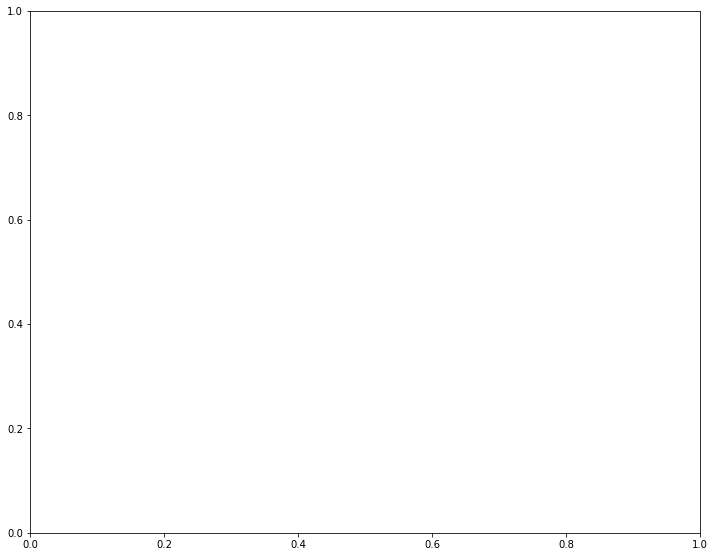

In [57]:
mags_adc_from_dac = [0.021, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.002, 0.014, 0.002, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.004, 0.003, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.002, 0.005, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.002, 0.003, 0.014, 0.007, 0.003, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.001, 0.000, 0.001, 0.001, 0.001, 0.000, 0.001, 0.001, 0.001, 0.001, 0.000, 0.000, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.002, 0.003, 0.003, 0.005, 0.009, 0.063, 0.013, 0.006, 0.004, 0.003, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.003, 0.003, 0.003, 0.003, 0.003, 0.004, 0.004, 0.004, 0.005, 0.005, 0.006, 0.007, 0.009, 0.012, 0.018, 0.034, 0.609, 0.038, 0.018, 0.012, 0.009, 0.007, 0.006, 0.005, 0.004, 0.004, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
test_freq = 21e3
plt.plot(freqs, mags_adc_from_dac, linewidth=3)
# plt.xscale("log")
# plt.yscale("log")
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.text(test_freq, 1e-3, f"{test_freq} Hz", fontsize = 23, rotation=85)
plt.axvline(x=test_freq, c="brown")
plt.xlabel("Frequency f[Hz]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal', fontsize=18)
plt.show()

With RC filter:
![Oscilloscope](DAC_21kHz_filter_glitch/SDS00087.BMP)

Without RC filter:
![Oscilloscope](DAC_21kHz_filter_glitch/SDS00088.BMP)
![Oscilloscope](DAC_21kHz_filter_glitch/SDS00089.BMP)

## 90Hz - without RC filter

In [ ]:
mags_adc_from_dac = [0.021, 0.022, 0.937, 0.021, 0.016, 0.014, 0.013, 0.012, 0.010, 0.009, 0.007, 0.006, 0.004, 0.003, 0.002, 0.002, 0.002, 0.002, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.001, 0.001, 0.000, 0.000, 0.001, 0.001, 0.000, 0.000, 0.000, 0.002, 0.001, 0.000, 0.000, 0.002, 0.001, 0.001, 0.001, 0.007, 0.001, 0.001, 0.001, 0.007, 0.001, 0.001, 0.001, 0.001, 0.000, 0.000, 0.001, 0.001, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.000, 0.001, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.001, 0.001, 0.000, 0.000, 0.001, 0.001, 0.000, 0.000, 0.003, 0.001, 0.001, 0.000, 0.003, 0.001]
test_freq = 90
plt.plot(freqs, mags_adc_from_dac, linewidth=3)
plt.xscale("log")
# plt.yscale("log")
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.text(test_freq, 1e-3, f"{test_freq} Hz", fontsize = 23, rotation=85)
plt.axvline(x=test_freq, c="brown")
plt.xlabel("Frequency f[Hz]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal', fontsize=18)
plt.show()

## 21kHz - without RC filter

In [ ]:
mags_adc_from_dac = [0.002, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.001, 0.000, 0.001, 0.001, 0.001, 0.000, 0.001, 0.001, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000, 0.001, 0.000, 0.001, 0.000, 0.001, 0.001, 0.001, 0.001, 0.000, 0.001, 0.000, 0.001, 0.001, 0.001, 0.001, 0.000, 0.000, 0.001, 0.001, 0.000, 0.000, 0.001, 0.000, 0.000, 0.000, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.003, 0.003, 0.003, 0.003, 0.003, 0.004, 0.004, 0.004, 0.004, 0.004, 0.005, 0.005, 0.006, 0.006, 0.007, 0.008, 0.009, 0.011, 0.014, 0.018, 0.027, 0.052, 0.930, 0.058, 0.028, 0.018, 0.014, 0.011, 0.009, 0.008, 0.007, 0.006, 0.005, 0.005, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
test_freq = 21e3
plt.plot(freqs, mags_adc_from_dac, linewidth=3)
# plt.xscale("log")
# plt.yscale("log")
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.text(test_freq, 1e-3, f"{test_freq} Hz", fontsize = 23, rotation=85)
plt.axvline(x=test_freq, c="brown")
plt.xlabel("Frequency f[Hz]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal', fontsize=18)
plt.show()

The filter is not needed.
Checkpoint in [zip](Example_2_testsignal_FFT_DAC.zip)

# Implementing matrix controller

NVICs (lower value -> igher priority):
- DMA2 (half/full finish of ADC sampling batch) - ftriggered executs function to evaluate FFT and animate. About 54 Hz refreshrate. HIGH priority.
- DMA1-5 (DAC) - low priority or none.
- DMA1-4 (SPI/LED)
- TIM7 - trigger animation display/display controller

Other:
- TIM6 - timer for measuring sampling refreshrate, sampling time etc.
- TIMx  - timer for measuring fft refreshrate//remove

In [58]:
led_period = 1.2e-6

led_res = 50e-6
led_count = 399+14
total_time = led_period*led_count + led_res
print(f"Drawing time: {total_time*1e3} ms, FPS: {round(1/total_time, 2)}")

print(f"SPI clk {round((1/(led_period + 150e-9*2))/1e3, 2)} to {round((1/(led_period - 150e-9*2))/1e3, 2)} kb/s")

apb2clk = 90e6

Drawing time: 0.5456000000000001 ms, FPS: 1832.84
SPI clk 666.67 to 1111.11 kb/s


## Swipe frequencies

const float32_t SWIPE_FREQS[50] = {22.0, 30.3, 55.3, 96.9, 155.1, 230.0, 321.5, 429.7, 554.5, 696.0, 854.1, 1028.8, 1220.2, 1428.2, 1652.9, 1894.2, 2152.1, 2426.7, 2717.9, 3025.8, 3350.3, 3691.4, 4049.2, 4423.7, 4814.7, 5222.4, 5646.8, 6087.8, 6545.4, 7019.7, 7510.6, 8018.2, 8542.4, 9083.2, 9640.7, 10214.9, 10805.6, 11413.0, 12037.1, 12677.8, 13335.1, 14009.1, 14699.7, 15407.0, 16130.9, 16871.4, 17628.6, 18402.4, 19192.9, 20000.0};



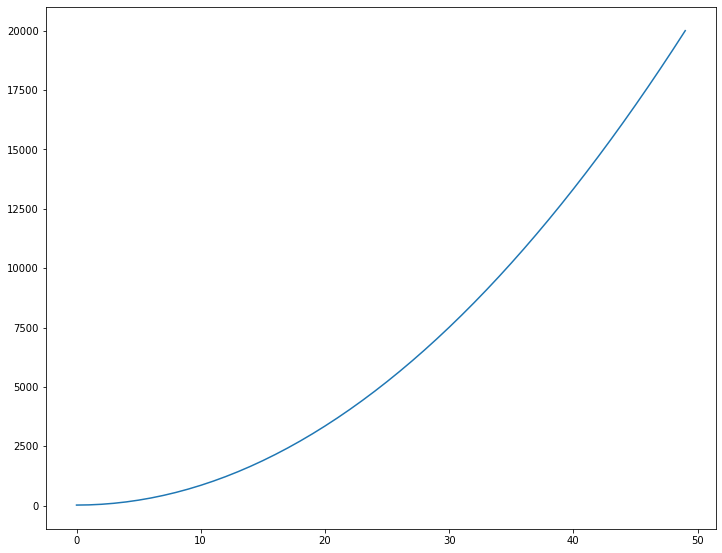

In [59]:
import math
swipe_steps = 50
swipe_min_freq = 22
swipe_max_freq = 20e3

swipe_freqs = [swipe_min_freq+(swipe_max_freq-swipe_min_freq)*((i/(swipe_steps-1))**2) for i in range(swipe_steps)]

print(f"const float32_t SWIPE_FREQS[{swipe_steps}] = " + "{" + str([round(sfrq, 1) for sfrq in swipe_freqs])[1:-1] + "};\n")

plt.plot(swipe_freqs)
plt.show()

## ES2812B controller using SPI

In [60]:
print('8 bit modulation of 1 bit - higher resolution')
fclk = 7.256
print('SPI fclk', fclk, 'MHz')
print('Low state', (1/fclk) * 3, 'us')
print('High state', (1/fclk) * 6, 'us')
print('T', 8/fclk, 'us\n\n')

print('4 bit modulation of 1 bit - lower resolution')
fclk = 26/8
print('SPI fclk', fclk, 'MHz')
print('Low state', (1/fclk) * 1, 'us')
print('High state', (1/fclk) * 3, 'us')
print('T', 4/fclk, 'us\n\n')




print('RES needs', math.ceil(50/(4/fclk)), 'WS2812B bits')
print('Total duration of entire frame with RES', (399+14)*4/fclk + 50, 'us\n\n')
print('Using uint32_t total length of array is:', arrlen := (399+14)*3 + 6, 'memory needed: ', 32*arrlen/8e3, 'kB')


8 bit modulation of 1 bit - higher resolution
SPI fclk 7.256 MHz
Low state 0.4134509371554575 us
High state 0.826901874310915 us
T 1.1025358324145533 us


4 bit modulation of 1 bit - lower resolution
SPI fclk 3.25 MHz
Low state 0.3076923076923077 us
High state 0.9230769230769231 us
T 1.2307692307692308 us


RES needs 41 WS2812B bits
Total duration of entire frame with RES 558.3076923076924 us


Using uint32_t total length of array is: 1245 memory needed:  4.98 kB


## uint8_t to uint32_t LUT

In [61]:
MODS = {0:0x8, 1:0xE}
def channel_to_modulate(ch):
    result = 0;
    for i in range(8):
        val = MODS[ch >> (i + (-1 if i%2 else 1)) & 1]
        result |= val << (7-i)*4
    return result
        
channel = 0xF1
uint32 = channel_to_modulate(channel)
print(bin(channel), bin(uint32), sep='\n')

color_lut = [channel_to_modulate(i) for i in range(256)]

print(f"const uint32_t COLOR_LUT[{'256'}] = " + "{" + str(color_lut)[1:-1] + "};\n")


0b11110001
0b10001110100010001110111011101110
const uint32_t COLOR_LUT[256] = {2290649224, 2391312520, 3901261960, 4001925256, 2291042440, 2391705736, 3901655176, 4002318472, 2296940680, 2397603976, 3907553416, 4008216712, 2297333896, 2397997192, 3907946632, 4008609928, 2290650760, 2391314056, 3901263496, 4001926792, 2291043976, 2391707272, 3901656712, 4002320008, 2296942216, 2397605512, 3907554952, 4008218248, 2297335432, 2397998728, 3907948168, 4008611464, 2290673800, 2391337096, 3901286536, 4001949832, 2291067016, 2391730312, 3901679752, 4002343048, 2296965256, 2397628552, 3907577992, 4008241288, 2297358472, 2398021768, 3907971208, 4008634504, 2290675336, 2391338632, 3901288072, 4001951368, 2291068552, 2391731848, 3901681288, 4002344584, 2296966792, 2397630088, 3907579528, 4008242824, 2297360008, 2398023304, 3907972744, 4008636040, 2290649230, 2391312526, 3901261966, 4001925262, 2291042446, 2391705742, 3901655182, 4002318478, 2296940686, 2397603982, 3907553422, 4008216718, 229733390

In [62]:

print('DAC z Timera 2 APB1, lol 703000-1')
tim2_freq = 52e6 / (5200)
print(tim2_freq/128, 'Hz')

print('\n\nNa oscyloskopie wyszlo ze czestotliwosc toggla od przerwania z ADC DAC to 20,5Hz UWAGA! dla polowy !!')
print(1024 * 20.5, 'Hz')
print('ADC z APB2 perip')

clocks = 15 + 144
t = clocks * 1/(52e6/8)
print('Sampling freq:', 1e-3/t, 'kHz')
print('Sampling time:', (1024*t)*1e3, 'ms')
print('Osciloscope check:', 1/(2*1024*t), 'Hz', 'powinno byc 20.5 Hz')

print(2**11)



DAC z Timera 2 APB1, lol 703000-1
78.125 Hz


Na oscyloskopie wyszlo ze czestotliwosc toggla od przerwania z ADC DAC to 20,5Hz UWAGA! dla polowy !!
20992.0 Hz
ADC z APB2 perip
Sampling freq: 40.88050314465409 kHz
Sampling time: 25.048615384615385 ms
Osciloscope check: 19.96118317610063 Hz powinno byc 20.5 Hz
2048


## HSV opt

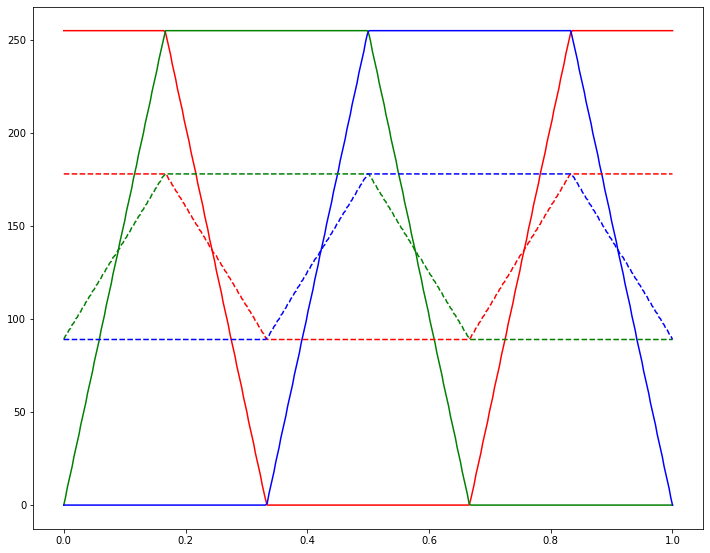

In [63]:
import colorsys

def hsv2rgb(h,s,v):
    return tuple(round(i * 255) for i in colorsys.hsv_to_rgb(h,s,v))

hsv2rgb(0.5,0.5,0.5)

hue = np.asarray(np.linspace(0,1,360))
r, g, b = map(list, zip(*[hsv2rgb(h, 1, 1) for h in hue ]))
plt.plot(hue, r, 'r')
plt.plot(hue, g, 'g')
plt.plot(hue, b, 'b')

r, g, b = map(list, zip(*[hsv2rgb(h, 0.5, 0.7) for h in hue ]))
plt.plot(hue, r, '--r')
plt.plot(hue, g, '--g')
plt.plot(hue, b, '--b')
plt.show()




In [64]:
data_len = 399+14
print(data_len)
# dataprint = [(i*12331%255, round((i*0.1111117+2.123421)%255), round((i*0.8511117-1.123421)%255)) for i in range(data_len)]
def gendata(i):
    res = "{.h=" + str(i*12331%255)
    res += ",.s=" + str(i*11%255)
    res += ",.v=" + str(i*2211%255)+"},"
    return res 
    

print('{' + ''.join([gendata(d) for d in range(data_len)])[0:-1] + '}')

413
{{.h=0,.s=0,.v=0},{.h=91,.s=11,.v=171},{.h=182,.s=22,.v=87},{.h=18,.s=33,.v=3},{.h=109,.s=44,.v=174},{.h=200,.s=55,.v=90},{.h=36,.s=66,.v=6},{.h=127,.s=77,.v=177},{.h=218,.s=88,.v=93},{.h=54,.s=99,.v=9},{.h=145,.s=110,.v=180},{.h=236,.s=121,.v=96},{.h=72,.s=132,.v=12},{.h=163,.s=143,.v=183},{.h=254,.s=154,.v=99},{.h=90,.s=165,.v=15},{.h=181,.s=176,.v=186},{.h=17,.s=187,.v=102},{.h=108,.s=198,.v=18},{.h=199,.s=209,.v=189},{.h=35,.s=220,.v=105},{.h=126,.s=231,.v=21},{.h=217,.s=242,.v=192},{.h=53,.s=253,.v=108},{.h=144,.s=9,.v=24},{.h=235,.s=20,.v=195},{.h=71,.s=31,.v=111},{.h=162,.s=42,.v=27},{.h=253,.s=53,.v=198},{.h=89,.s=64,.v=114},{.h=180,.s=75,.v=30},{.h=16,.s=86,.v=201},{.h=107,.s=97,.v=117},{.h=198,.s=108,.v=33},{.h=34,.s=119,.v=204},{.h=125,.s=130,.v=120},{.h=216,.s=141,.v=36},{.h=52,.s=152,.v=207},{.h=143,.s=163,.v=123},{.h=234,.s=174,.v=39},{.h=70,.s=185,.v=210},{.h=161,.s=196,.v=126},{.h=252,.s=207,.v=42},{.h=88,.s=218,.v=213},{.h=179,.s=229,.v=129},{.h=15,.s=240,.v=45},{.

## Colors compare

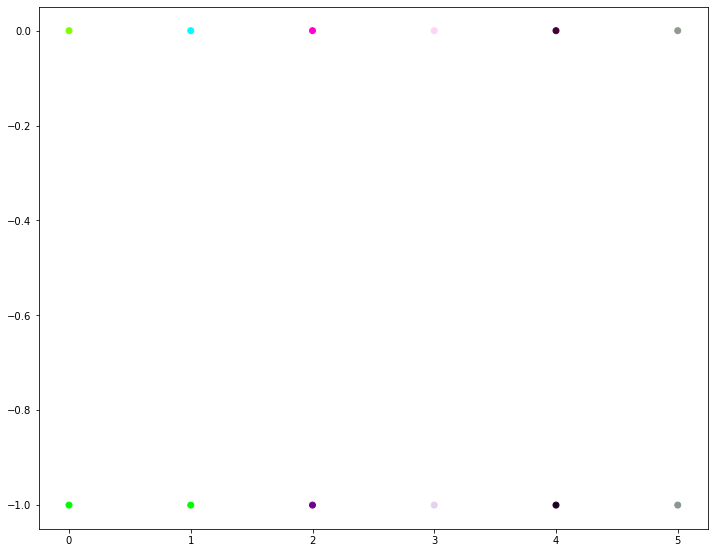

RGB compare:
[(126, 255, 0), (0, 252, 255), (255, 0, 210), (255, 211, 247), (66, 0, 54), (143, 155, 140)]
[(0, 251, 0), (0, 251, 0), (111, 0, 139), (229, 210, 234), (28, 0, 36), (139, 151, 142)]


In [65]:
hsv_insput =    [(64, 255, 255), (128,255,255), (220,255,255), (220,44,255), (220,255,66), (77,25,155)]


rgb_reference = [tuple(round(channel*255) for channel in colorsys.hsv_to_rgb(h/255, s/255, v/255)) for h,s,v in hsv_insput]
# rgb_ref_res   = [(126, 255, 0), (0, 252, 255), (255, 0, 210), (255, 211, 247), (66, 0, 54), (143, 155, 140)]
rgb_results   = [(0,   251, 0), (0, 251, 0), (111,0,139), (229,210,234), (28,0,36), (139,151,142)]

plt.scatter(list(range(6)), 6*[0], c=np.array(rgb_reference)/255)
plt.scatter(list(range(6)), 6*[-1], c=np.array(rgb_results)/255)
plt.show()

print('RGB compare:')
print(rgb_reference)
print(rgb_results)


## Generating colors tables

In [ ]:
# fire tongue
# fire_tingue